# AE98 Electron Beam Shadowgraphy

## Notebook Objectives
The goal of this notebook is to mimic the analysis of Kasim et. al. (2017) to calculate the deflection angle of the electron beam in the AE98 experiment from e- shadowgraphy images.

## 1. Voronoi Tesselation and Lloyd's Algorithm

Voronoi and power diagrams are tesselations of 2D space around a certain number of key points or **sites**. Every point in the space is closest to one of the sites, and so we can divide space into sites and the collection of points those sites. Mathematically, the ith site has a **power cell** defined via

\begin{align}
|\vec{r}_0 - \vec{r}_{0i}|^2 -w_i \leq |\vec{r}_0 - \vec{r}_{0j}|^2 -w_j
\end{align}

for all other sites $j$, where $w_i, w_j$ are the weights of each cell.

In [1]:
import numpy as np
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import tesselate as tess

%load_ext autoreload
%autoreload 2

# set plotting style
%matplotlib inline
plt.style.reload_library()
plt.style.use('ucla_presentations')

# define a handy function for wiping the ticks and labeles off of plot axes
def no_ticks(ax):
    return ax.tick_params(left=False,
                          bottom=False,
                          labelleft=False,
                          labelbottom=False)


Python packages like scipy have built in functions for Voronoi diagrams, but these do not allow us to use additive weights, which we'll need for the analysis later on. Best to write our own methods for calculating power diagrams so we can tweak and optimize from there.

### A Straightforward First Pass

The most intuitive way to make power diagrams that will be applied to pixellated data is to directly calculate them using numpy arrays (matrices). Then we can take advantage of numpy functions to keep things running quickly. 

This approach works, but it scales with the size of your data and gets very slow when we start using large datasets and many sites. I've kept this all here for posterity and because it demonstrates the mechanics of power diagrams and lloyd relaxation more clearly, but the more mathematically sophisticated approach I'll use later is significantly faster.

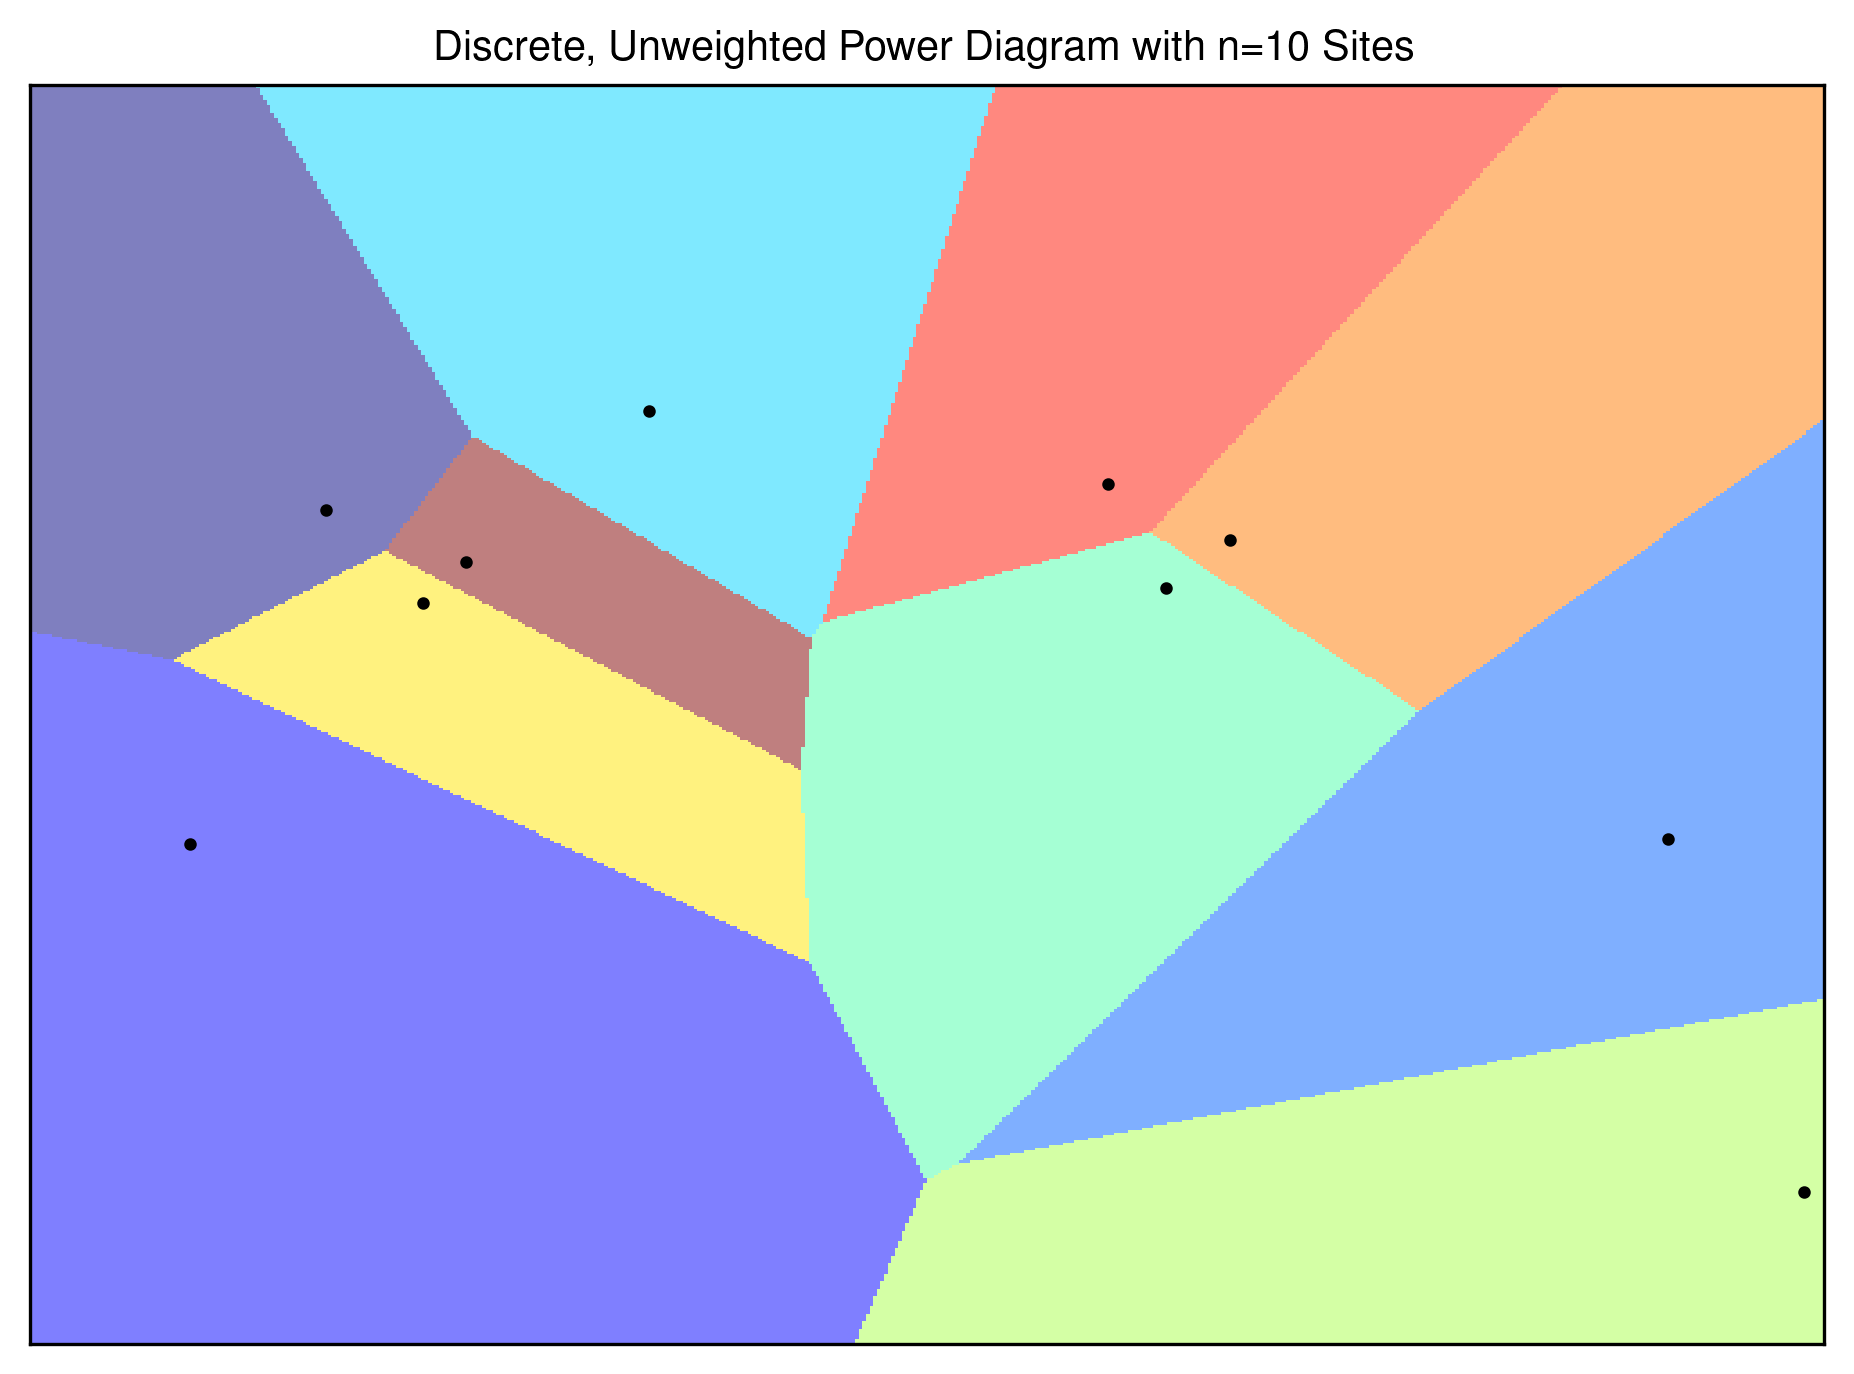

CPU times: user 843 ms, sys: 1.4 s, total: 2.24 s
Wall time: 841 ms


In [2]:
%%time
def voronoi_grid(points, shape, weights = 0):
    """
    Generate an array of size (shape, len(points)) that contains the
    indices of each pixel's voronoi cell
    """
    
    # Create arrays of indices with the right shape
    y, x = np.indices(shape)
    y_0, x_0 = points[:,0], points[:,1]
        
    # Calculate the distance from each point to each center
    d2 = (x[:,:,np.newaxis] - x_0[np.newaxis, np.newaxis,:])**2 +\
         (y[:,:,np.newaxis] - y_0[np.newaxis, np.newaxis,:])**2 - weights
    
    #print(f"distances = \n{d2}")

    # Find the index of the nearest center to each point
    nearest_center = np.argmin(d2, axis=2)
    
    #print(f"nearest center = \n{nearest_center}")

    return nearest_center

n=10
h, w = 500, 500
random_y, random_x = np.random.randint(h, size=n), np.random.randint(w, size=n)
points = np.array([random_y, random_x]).T

Y, X = np.indices((h,w))

grid = voronoi_grid(points, (h, w) )

fig, ax = plt.subplots()

ax.pcolormesh(X,Y, grid, cmap='jet', alpha=.5)
ax.plot(random_x, random_y,'ok')
no_ticks(ax)
ax.set_title(f"Discrete, Unweighted Power Diagram with n={n} Sites")
plt.show()


### Lloyd's Algorithm

Lloyd's algorithm is an iterative method for dividing a space into cells of approximately equal area. The method proceeds like this:

1. Distribute a certain number of sites randomly on the plane
2. Construct the Voronoi diagram for those sites
3. Calculate the centroid of each cell
4. Move each site to the centroid of its cell
5. Repeat from step 2 until a stop condition is met.

Here's a quick demonstration of just one iteration of Lloyd's algorithm so you can see the way this works:

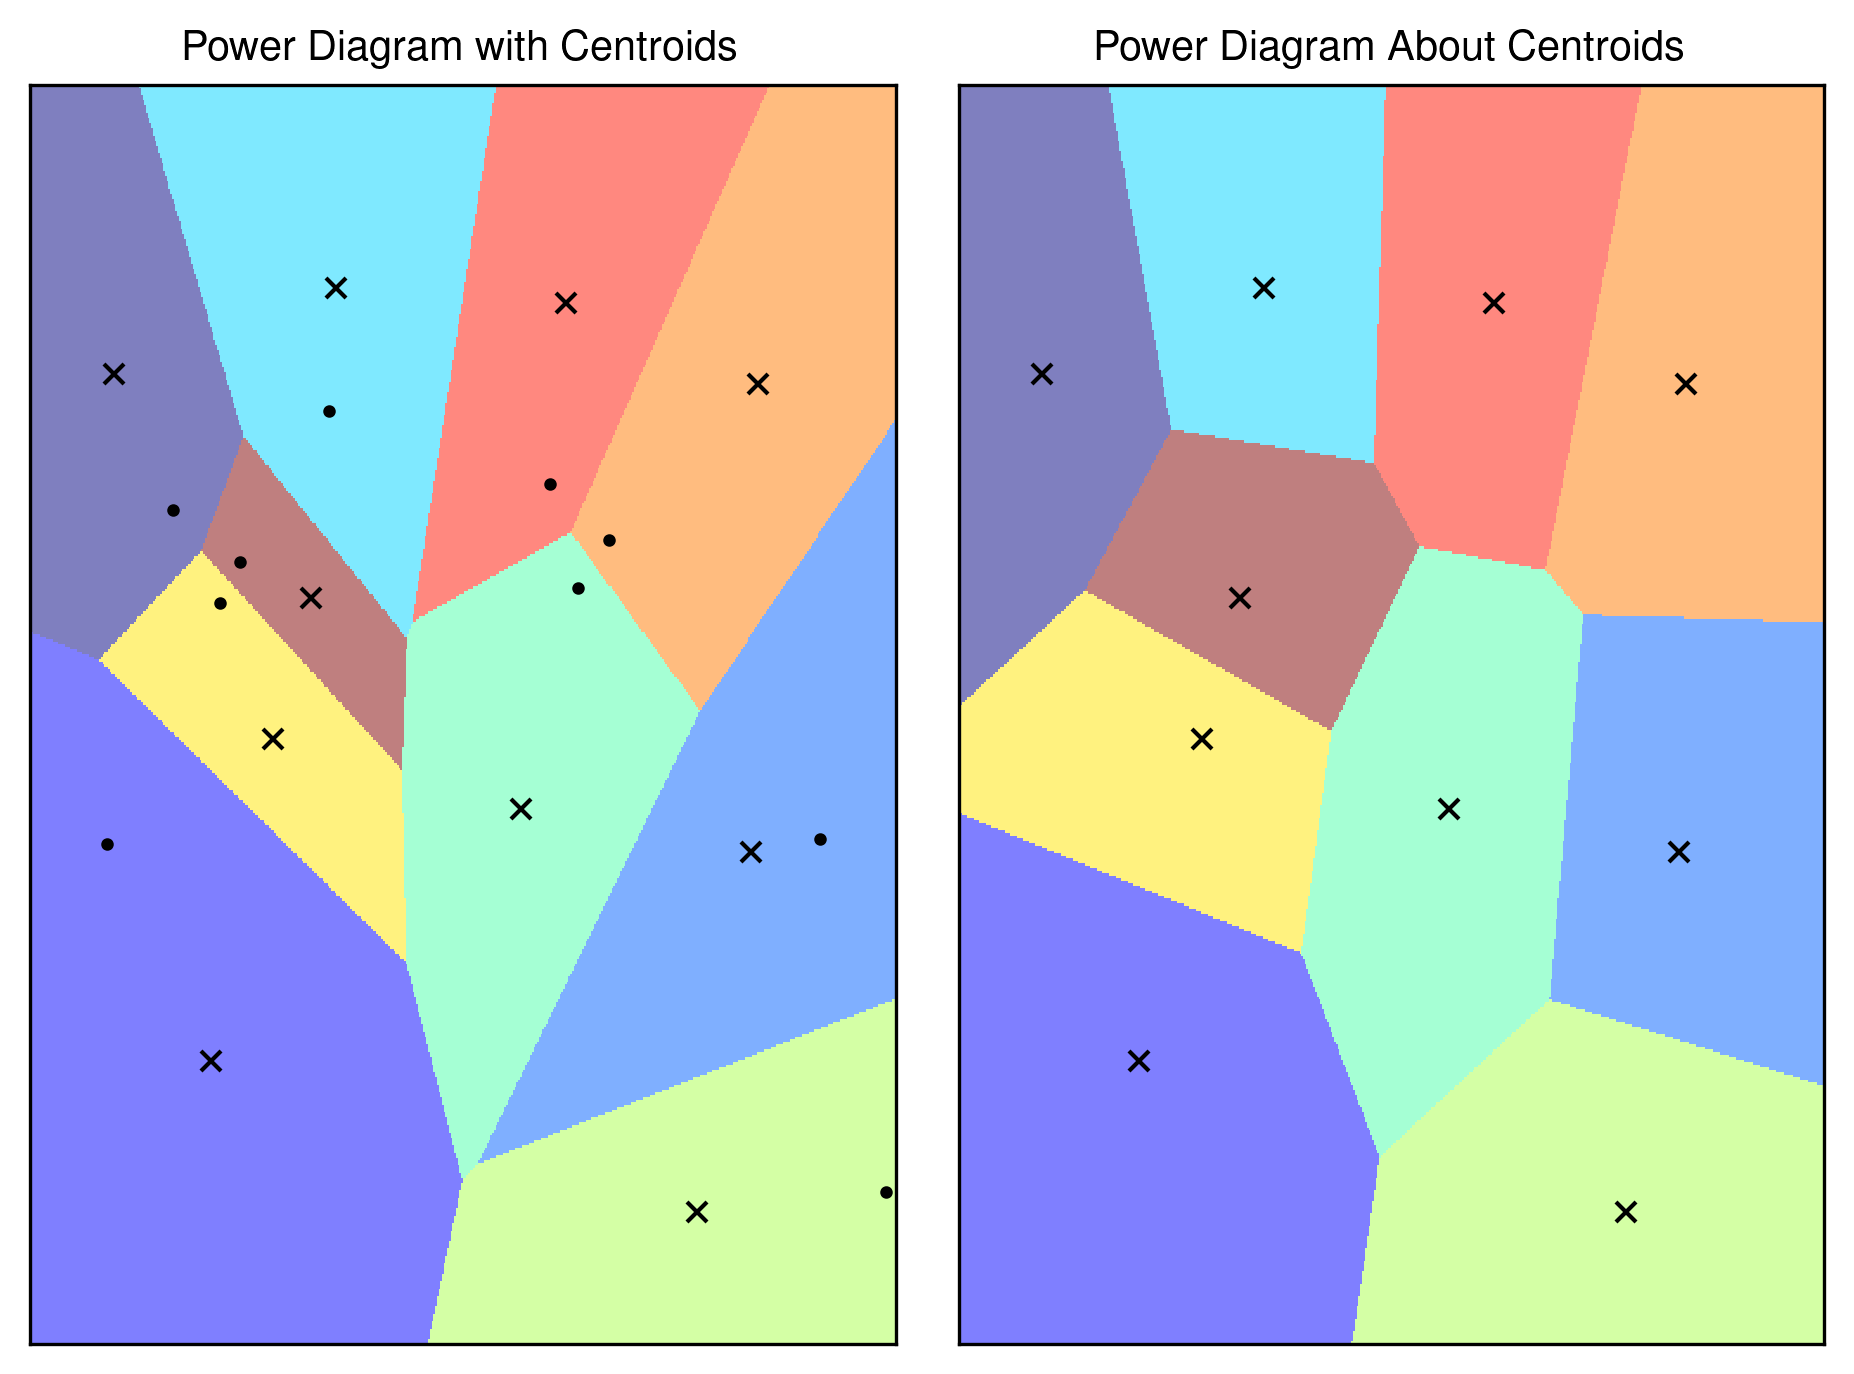

CPU times: user 764 ms, sys: 224 ms, total: 989 ms
Wall time: 763 ms


In [3]:
%%time
def find_centroids(n, grid):
    """
    Takes a 2D array of voronoi cell indices and calculates the centroid position of each cell
    """
    centroids = np.zeros((n,2), dtype=int)
    
    # Loop over the number of cells

    for i in range(n):
        # First we need to get all the points in a region
        points = np.argwhere(grid == i)
        # Get the number of points in the centroid
        num = points.shape[0]
        #print(f"for i = {i} found {num} points in cell:\n\tx = {points[:,1]}, y = {points[:,0]}")
        centroids[i] = np.rint( np.sum(points, axis=0) / num)
        #print(f"\tFound centroid = ({centroids[i,1]},{centroids[i,0]})")
    
    return centroids


centroids = find_centroids(n, grid)

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.pcolormesh(X,Y, grid, cmap='jet', alpha=.5)
ax1.plot(random_x, random_y,'ok', label='Sites')
ax1.plot(centroids[:,1], centroids[:,0],'kx', markersize=5, label='Centroids')
no_ticks(ax1)
ax1.set_title(f"Power Diagram with Centroids")
#ax1.legend()
    
grid_c = voronoi_grid(centroids, (h, w) )

ax2.pcolormesh(X,Y, grid_c, cmap='jet', alpha=.5)
ax2.plot(centroids[:,1], centroids[:,0],'kx', markersize=5, label='Centroids')
no_ticks(ax2)
ax2.set_title(f"Power Diagram About Centroids")
plt.show()

Centroids no longer changing at i=45 iterations


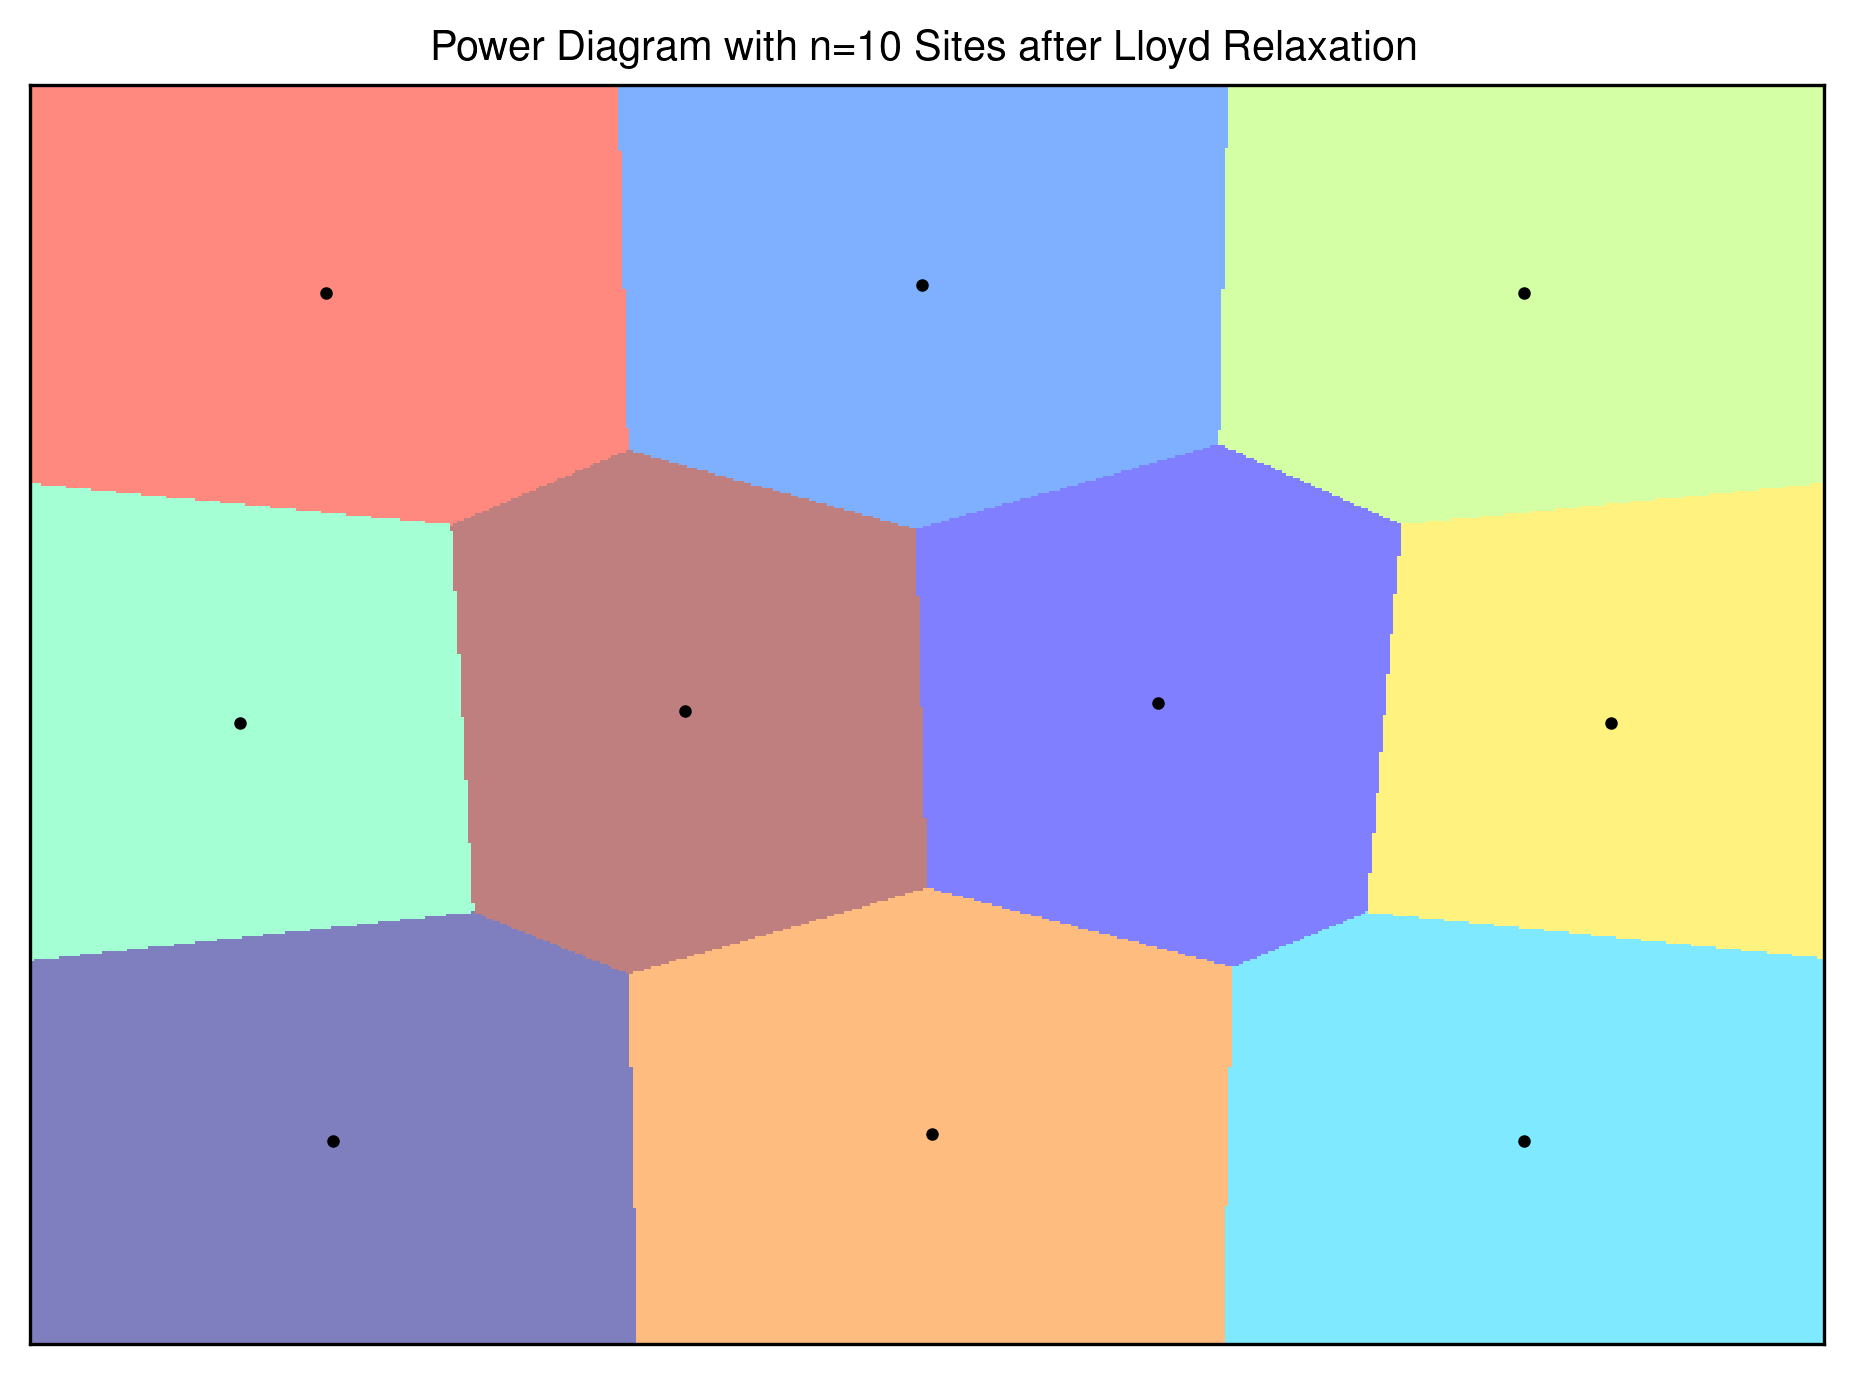

CPU times: user 2.11 s, sys: 623 ms, total: 2.74 s
Wall time: 2.51 s


In [4]:
%%time
def lloyd_distribute(n, shape, allowance = 0.1, MAXDEPTH = 1000):
    """
    Throw n sites onto a grid with shape, and use lloyd's algorithm to distribute them evenly
    within an allowance of the perfectly split area in each cell
    """
    
    ideal_volume = (shape[0] * shape[1]) / n
    threshold = ideal_volume * allowance
    Y, X = np.indices(shape)

    h, w = shape
    
    # Generate n random sites to start with
    random_y, random_x = np.random.randint(h, size=n), np.random.randint(w, size=n)
    random_points = np.array([random_y, random_x]).T

    grid = voronoi_grid(random_points, shape)
    

    centroids = find_centroids(n, grid)
    for i in range(MAXDEPTH):

        grid = voronoi_grid(centroids, shape)
        old_centroids = np.copy(centroids)
        centroids = find_centroids(n, grid)
        if np.array_equal(centroids,old_centroids):
            print(f"Centroids no longer changing at i={i+1} iterations")
            break
    
    return grid, centroids

lgrid, lpoints = lloyd_distribute(n, (h,w))

lgrid_offset = np.roll(np.roll(lgrid+1, 1, axis=0), 1, axis=1)-(lgrid+1)
y_edges, x_edges = np.nonzero(lgrid_offset)
#print(f"edges = {edges}")

grad_y, grad_x = np.gradient(lgrid)
edges = grad_x**2 + grad_y**2
y_edges, x_edges = np.nonzero(edges)
fig, ax = plt.subplots()

ax.pcolormesh(X,Y, lgrid, cmap='jet', alpha=.5)
#ax.pcolormesh(X,Y, edges, cmap='jet', alpha=1)
#ax.plot(x_edges, y_edges, 'k.', alpha=1)
ax.plot(lpoints[:,1], lpoints[:,0],'ok')
no_ticks(ax)
ax.set_title(f"Power Diagram with n={n} Sites after Lloyd Relaxation")
plt.show()



### Deeper Down the Geometry Hole

Scipy doesn't have a built-in way to calculate weighted Voronoi diagrams, so we can't *easily* take advantage of the more sophisticated algorithms written in C++ for this analysis. However, a fun property of Voronoi diagrams can help us out here. 

**A 2D Voronoi diagram is equivalent to the intersection of half-planes given by the projection of each site onto a 3D paraboloid.**

We can manipulate this paraboloid to give the weighting we want while still taking advantage of scipy's speedy C++ integrations using convex hull algorithms.

#### Delaunay Triangulation

The **dual** of a Voronoi diagram is the **Delaunay Triangulation**, shown in green here:

<p style="text-align:center;"><img src="voronoi_delaunay.png" alt="voronoi and delaulay diagrams" width="300"></p>

The Delaunay triangulation is the projection of the convex hull of the sites when lifted onto a hyperboloid, so if we use a weighted hyperbola equation to lift the sites from 2D to 3D and calculate the convex hull, we then have the weighted Delaunay triangulation on the 2D plane. Once we have these triangles, we can get the Voronoi or Power diagram from there.

This diagram from Hang Si's lecture notes demonstrates this projection onto the hyperbola:

<p style="text-align:center;"><img src="delaunay_projection.png" alt="delaulay diagram from 3D projection" width="500"></p>

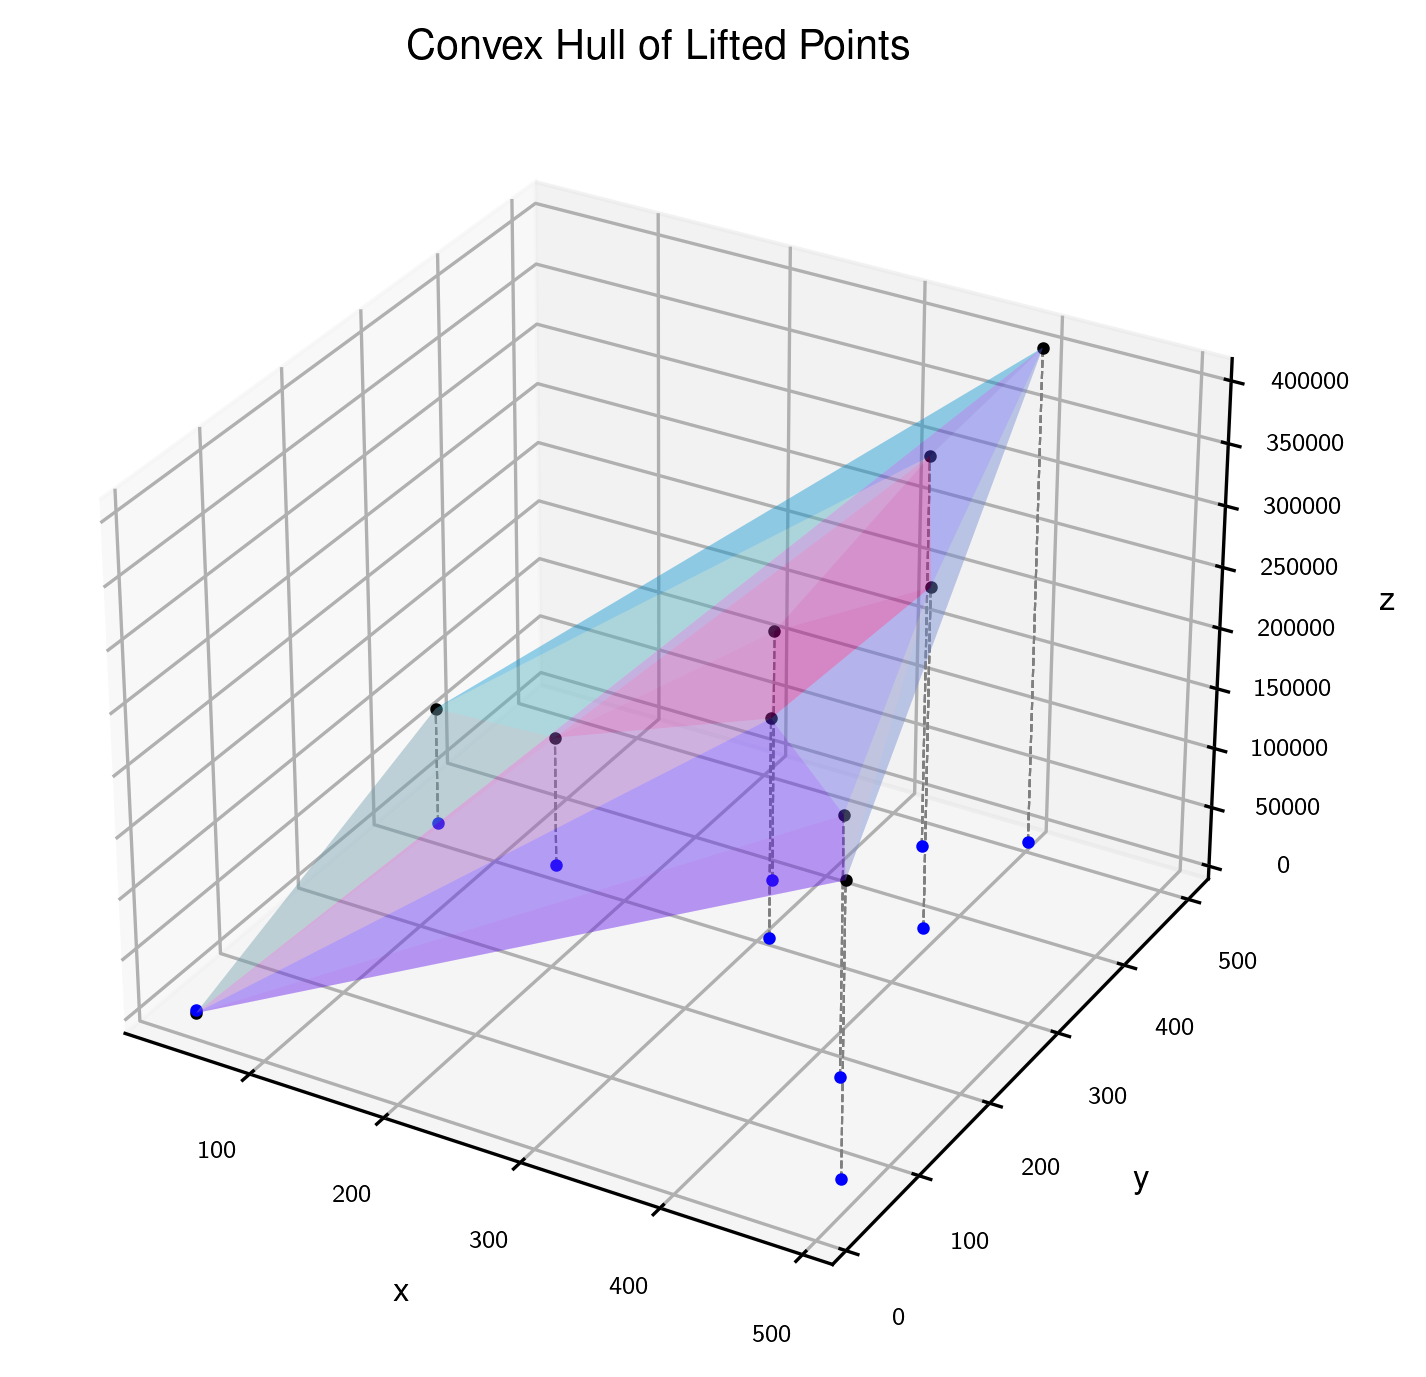

In [5]:
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib as mpl


# First we need to lift  our 2D points onto a weighted hyperbola
def lift_points(points, weights):
    """
    Lift 2D points onto 3D paraboloid for calculating weighted 
    Delaunay triangulations and Voronoi diagrams
    
    Arguments:
        points: 2D numpy array of point coordinates with shape (N, 2)
        weights: 1D numpy array of length N holding each points corresponding weight
        
    Returns:
        3D numpy array of coordinates with shape (N, 3) where the third column is 
        the z projection
    """
    z = np.sum(points * points, axis=1) - weights
    return np.hstack((points, z[np.newaxis,:].T))
    
# Demonstrating the data structure real quick
n=10
h, w = 500, 500
random_y, random_x = np.random.randint(h, size=n), np.random.randint(w, size=n)
points_xy = np.array([random_y, random_x]).T
#print(f"2D Points = \n{points_xy}")
weights = np.array([1,1,5,1,1,10,1,3,8,1])*500
#weights = np.zeros(n)
points_xyz = lift_points(points_xy, weights)
#print(f"Projection to 3D = \n{points_xyz}")

# Plot the 3D convex hull
fig = plt.figure()
ax = plt.axes(projection='3d')

hull = ConvexHull(points_xyz)

colors = mpl.cm.get_cmap(name='rainbow')(np.linspace(0,1,len(hull.simplices)))
for i, s in enumerate(hull.simplices):
    for j in s:
        x, y = [points_xyz[j,0],points_xyz[j,0]],[points_xyz[j,1],points_xyz[j,1]]
        ax.plot(x, y, [0,points_xyz[j, 2]], '--', color='grey', lw=0.5)
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot_trisurf(points_xyz[s, 0], points_xyz[s, 1], points_xyz[s, 2], color=colors[i], alpha=.25)

ax.plot(points_xyz[:, 0], points_xyz[:, 1], points_xyz[:, 2], 'ko')
ax.plot(points_xyz[:, 0], points_xyz[:, 1], 0, 'bo')
    
# Make axis labels
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.set_title('Convex Hull of Lifted Points')
plt.show()

The convex hull objects returned by scipy have the property <code>equations</code>, which is an array containing the normal vector $V$ and offset $b$ of each face of the hull, such that for any point $\vec{x}$ inside the convex hull,  $\vec{V}\cdot \vec{x} + b < 0$.

This means that any *lower-facing* faces of the hull will have normal vectors with negative z-components.

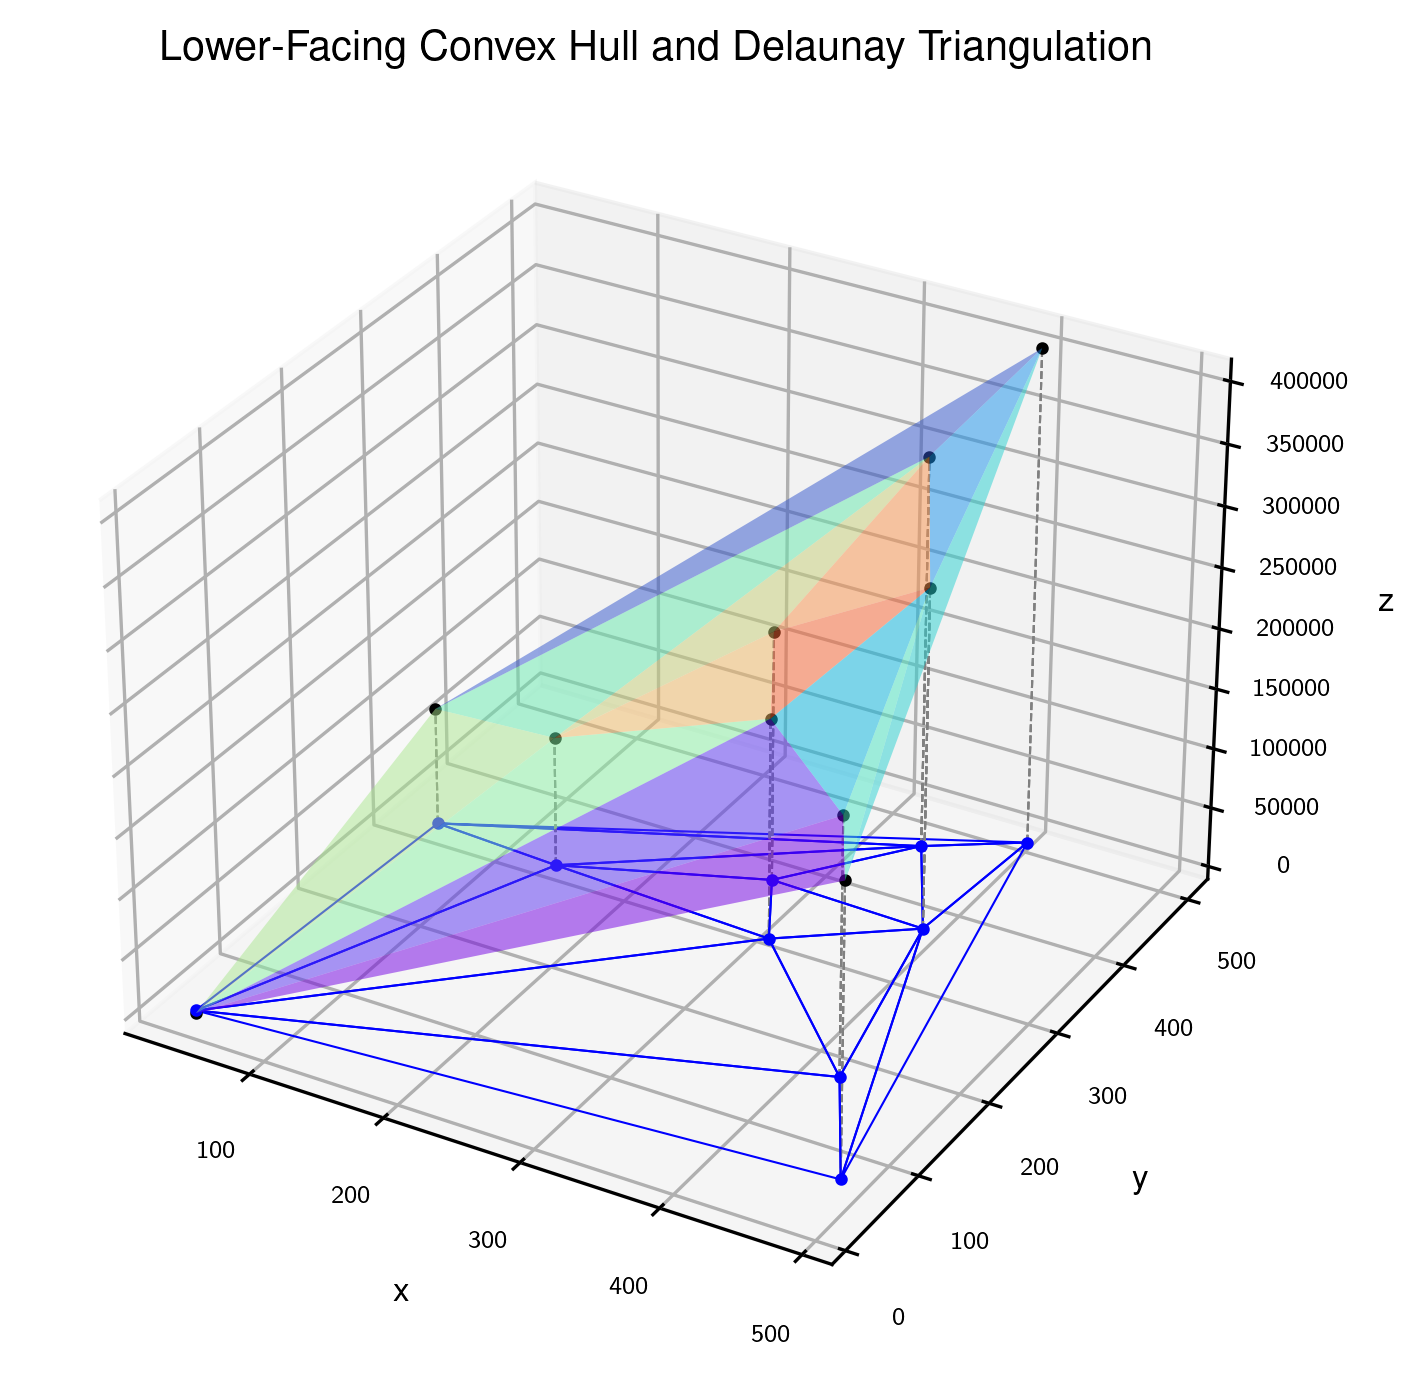

In [6]:
# Now we need to determine which faces of the convex hull are pointing down
def get_lower_facing(hull):
        return np.where(hull.equations[:,2] < 0)[0]
    
#print(f"Normal vectors of faces, (Vx, Vy, Vz, b): \n{hull.equations}")

lowers = get_lower_facing(hull)
# Plot the 3D convex hull
fig = plt.figure()
ax = plt.axes(projection='3d')

for i, s in enumerate(hull.simplices[lowers]):
    for j in s:
        x, y = [points_xyz[j,0],points_xyz[j,0]],[points_xyz[j,1],points_xyz[j,1]]
        ax.plot(x, y, [0,points_xyz[j, 2]], '--', color='grey', lw=0.5)
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot_trisurf(points_xyz[s, 0], points_xyz[s, 1], points_xyz[s, 2], color=colors[i], alpha=.5)
    
    # Projecting these back to z=0 gives the Delaunay Triangulation
    ax.plot(points_xyz[s, 0], points_xyz[s, 1], 0, 'b-', lw=0.5)

ax.plot(points_xyz[:, 0], points_xyz[:, 1], points_xyz[:, 2], 'ko')
ax.plot(points_xyz[:, 0], points_xyz[:, 1], 0, 'bo')
    
# Make axis labels
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.set_title('Lower-Facing Convex Hull and Delaunay Triangulation')
plt.show()

#### Calculating the dual graph

Now we have a weighted Delaunay triangulation, and we need to find the dual of this plot to get the weighted Voronoi diagram.

The vertices of each Voronoi cell are defined by the **weighted circumcenters** of all the triangles surrounding the site.

The coordinates of the unweighted circumcenter are

\begin{align}
U_x &= \frac{1}{D}\big((A_x^2 + A_y^2)(B_y - C_y)+(B_x^2 + B_y^2)(C_y - A_y)+(C_x^2 + C_y^2)(A_y - B_y)\big) \\
U_y &= \frac{1}{D}\big((A_x^2 + A_y^2)(C_x - B_x)+(B_x^2 + B_y^2)(A_x - C_x)+(C_x^2 + C_y^2)(B_x - A_x)\big) \\
D &= 2\big(A_x(B_y - C_y) + B_x(C_y - A_y) + C_x(A_y - B_y)\big)
\end{align}

However to take into account the weights this point is offset by *half the local gradient of the linear function defined by the three weights of the vertices*. In other words if $\boldsymbol{c}_{ijk}^0$ is the unweighted circumcenter, the weighted circumcenter is
\begin{align}
\boldsymbol{c}_{ijk} = \boldsymbol{c}_{ijk}^0 - \frac{1}{2}\big(\nabla w\big)_{ijk}
\end{align}

In reality we've *already calculated* the weighted circumcenters, because we have the normal vectors $\vec{V} = (V_x, V_y, V_z)$ of each face of the 3D convex hull. Projecting these vectors back down to the $z=0$ plane gives the weighted circumcenter for one of our triangles:
\begin{align}
\vec{c} = -\frac{ \vec{V}_\perp}{2 V_z}
\end{align}

We can double check this weighting by returning to the definition of a power diagram: each edge of a cell is defined by the intersection of the circles centered at two neighboring sites, with radii given by $\sqrt{w_i}$.

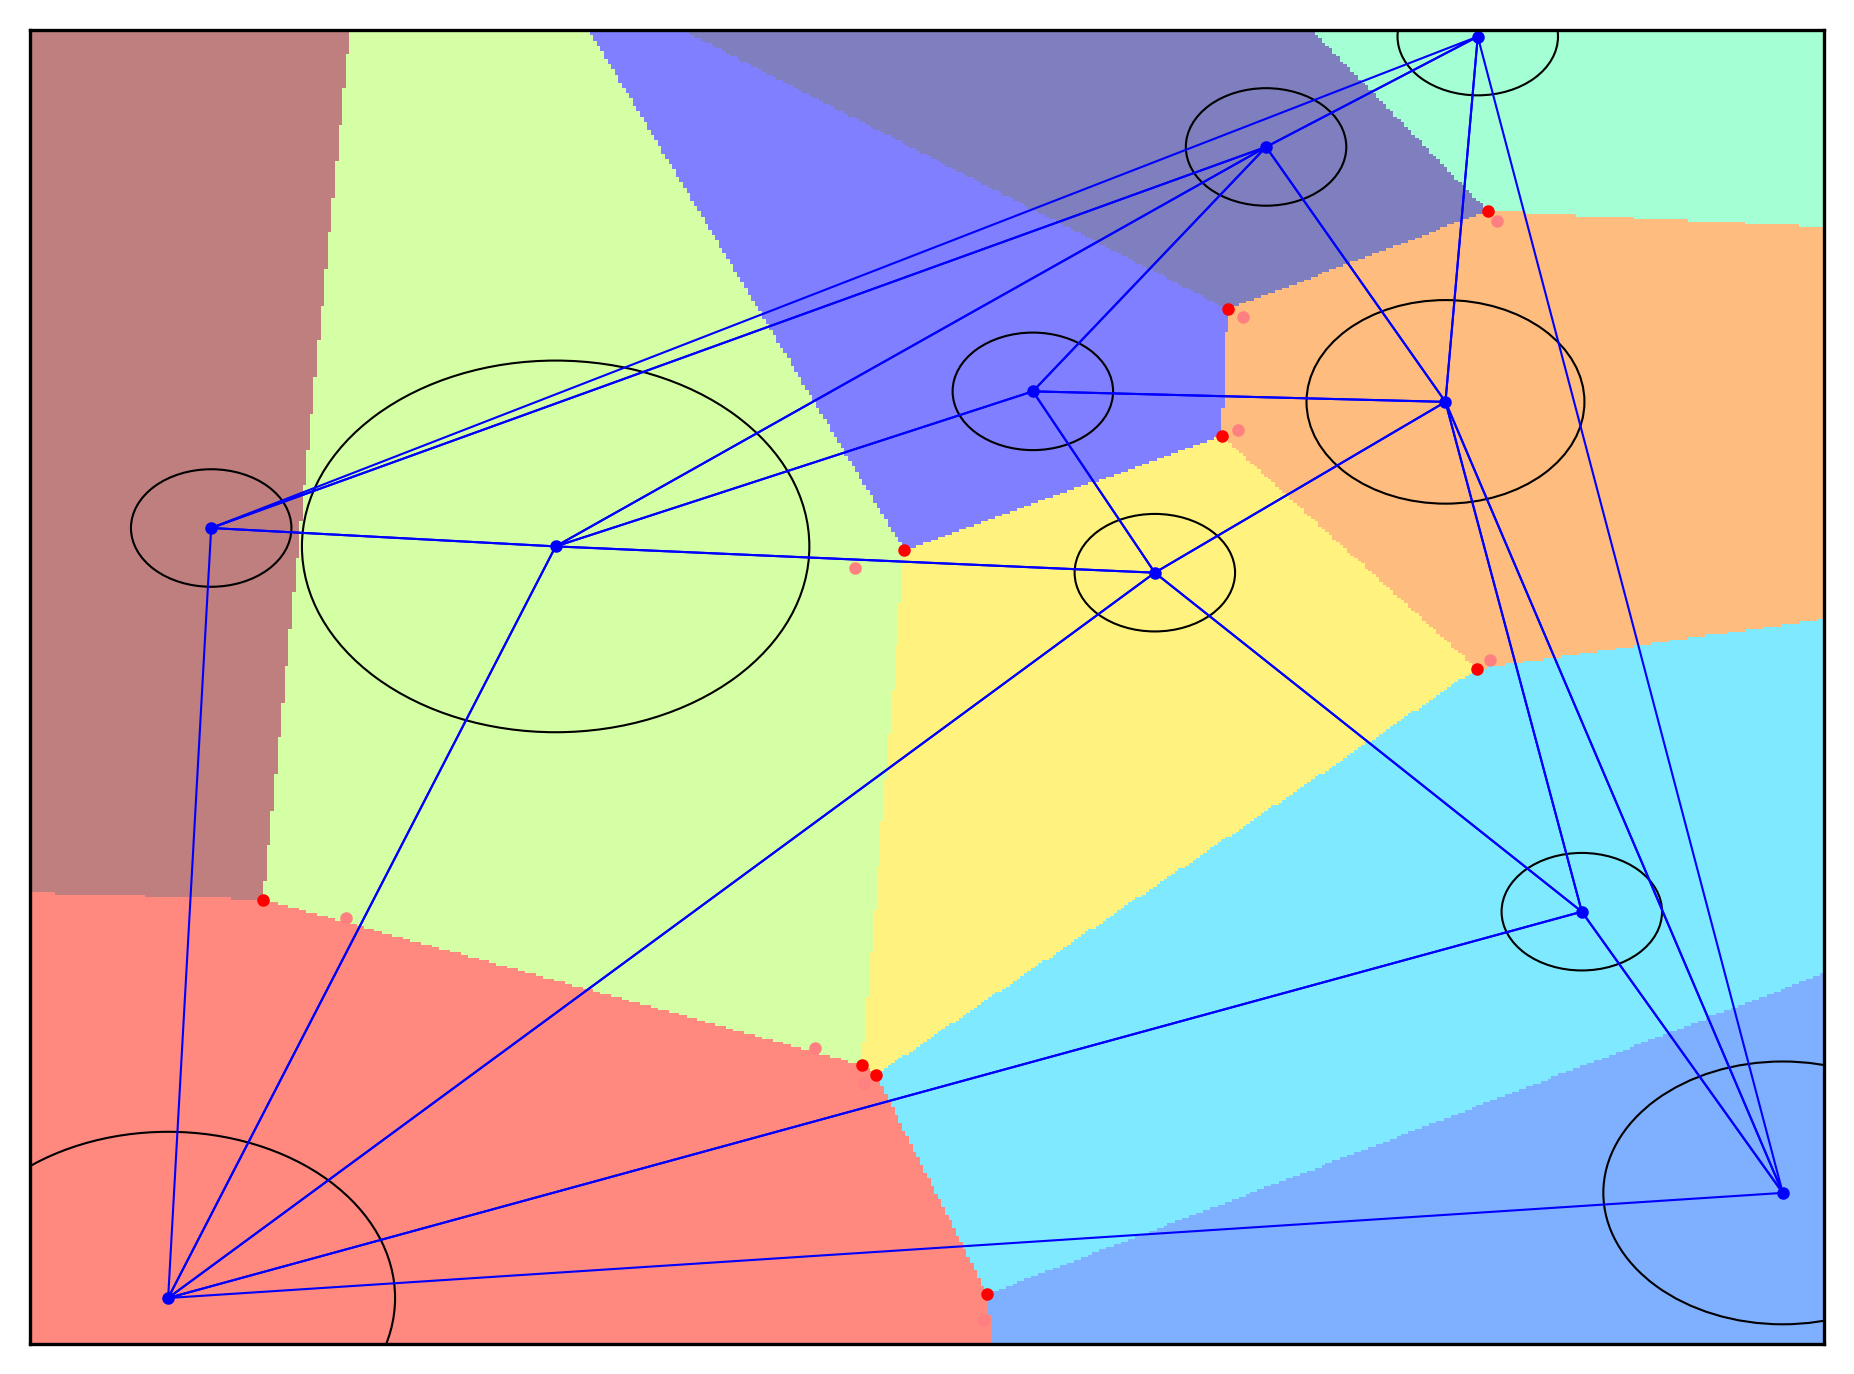

In [7]:
def circumcenter(points):
    """
    Calculates the unweighted circumcenter of the triangle defined by points
    Arguments:
        points: 2D ndarray of triangle vertices with form [[Ax, Ay],[Bx, By],[Cx, Cy]]
    
    Returns:
        circumcenter: [cx, cy] coordinates of the triangle's circumcenter
    """
    
    # Get the permutation needed for Ax(By - Cy), etc
    shifted = np.roll(points, -1, axis=0) - np.roll(points, 1, axis=0)
    flipped = np.fliplr(shifted)
    flipped[:,1] *= -1
    
    # Calculate the magnitude squared of each vertex vector
    mag = np.sum(points**2, axis=1)
    
    # Calculate the circumcenter
    D = 2 * np.sum(points[:,0] * flipped[:,0])
    return (mag @ flipped) / D


# Plot the circumcenter of each Delaunay triangle, including Voronoi cells from the old method to
# check our work

fig, ax = plt.subplots()
grid = voronoi_grid(points_xy, (h, w), weights)
X,Y = np.indices((h,w))
ax.pcolormesh(X,Y, grid, cmap='jet', alpha=.5)
ax.set_ylim(ax.get_ylim())
ax.set_xlim(ax.get_xlim())

# Grab the normal vectors of each face
eqns = (hull.equations[lowers])

for i, s in enumerate(hull.simplices[lowers]):
    # Show the difference between weighted and unweighted circumcenters
    cc = circumcenter(points_xyz[s, :-1])
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    
    # Projecting these back to z=0 gives the Delaunay Triangulation
    ax.plot(points_xyz[s, 0], points_xyz[s, 1],  'b-', lw=0.5)
    
    # Unweighted circumcenters in light red
    ax.plot(cc[0], cc[1], 'o', c = (1,.5,.5))
    
    # Get the weighted circumcenters from the convex hull
    verts = -0.5 * eqns[i, :2] / eqns[i, 2]
    ax.plot(verts[0], verts[1], 'ro')


# Draw the weights of each site
for point, weight in zip(points_xy, weights):
    ax.add_patch(plt.Circle((point[0], point[1]), np.sqrt(weight), color='black', fill=False, lw=0.5))
ax.plot(points_xyz[:, 0], points_xyz[:, 1], 'bo')

no_ticks(ax)
plt.show()

#### What about the edges?

Right now we have several Voronoi cells with vertices that are infinite. As you can see in the plot above, this weighted circumcenter calculation does not give us the vertices along the edges of the box. In order to determine those vertices, we can take two different approaches:

1. Mirror the sites over each edge of the bounding box before calculating the convex hull so that there will always be Voronoi edges on the boundaries.
2. Calculate the unit vectors for the infinite edges and project those lines to the edges of the box.

The first approach is the easiest to implement, so let's try that first. In the next plot you can see several vertices of the Voronoi diagram along the edges of the original bounding box.

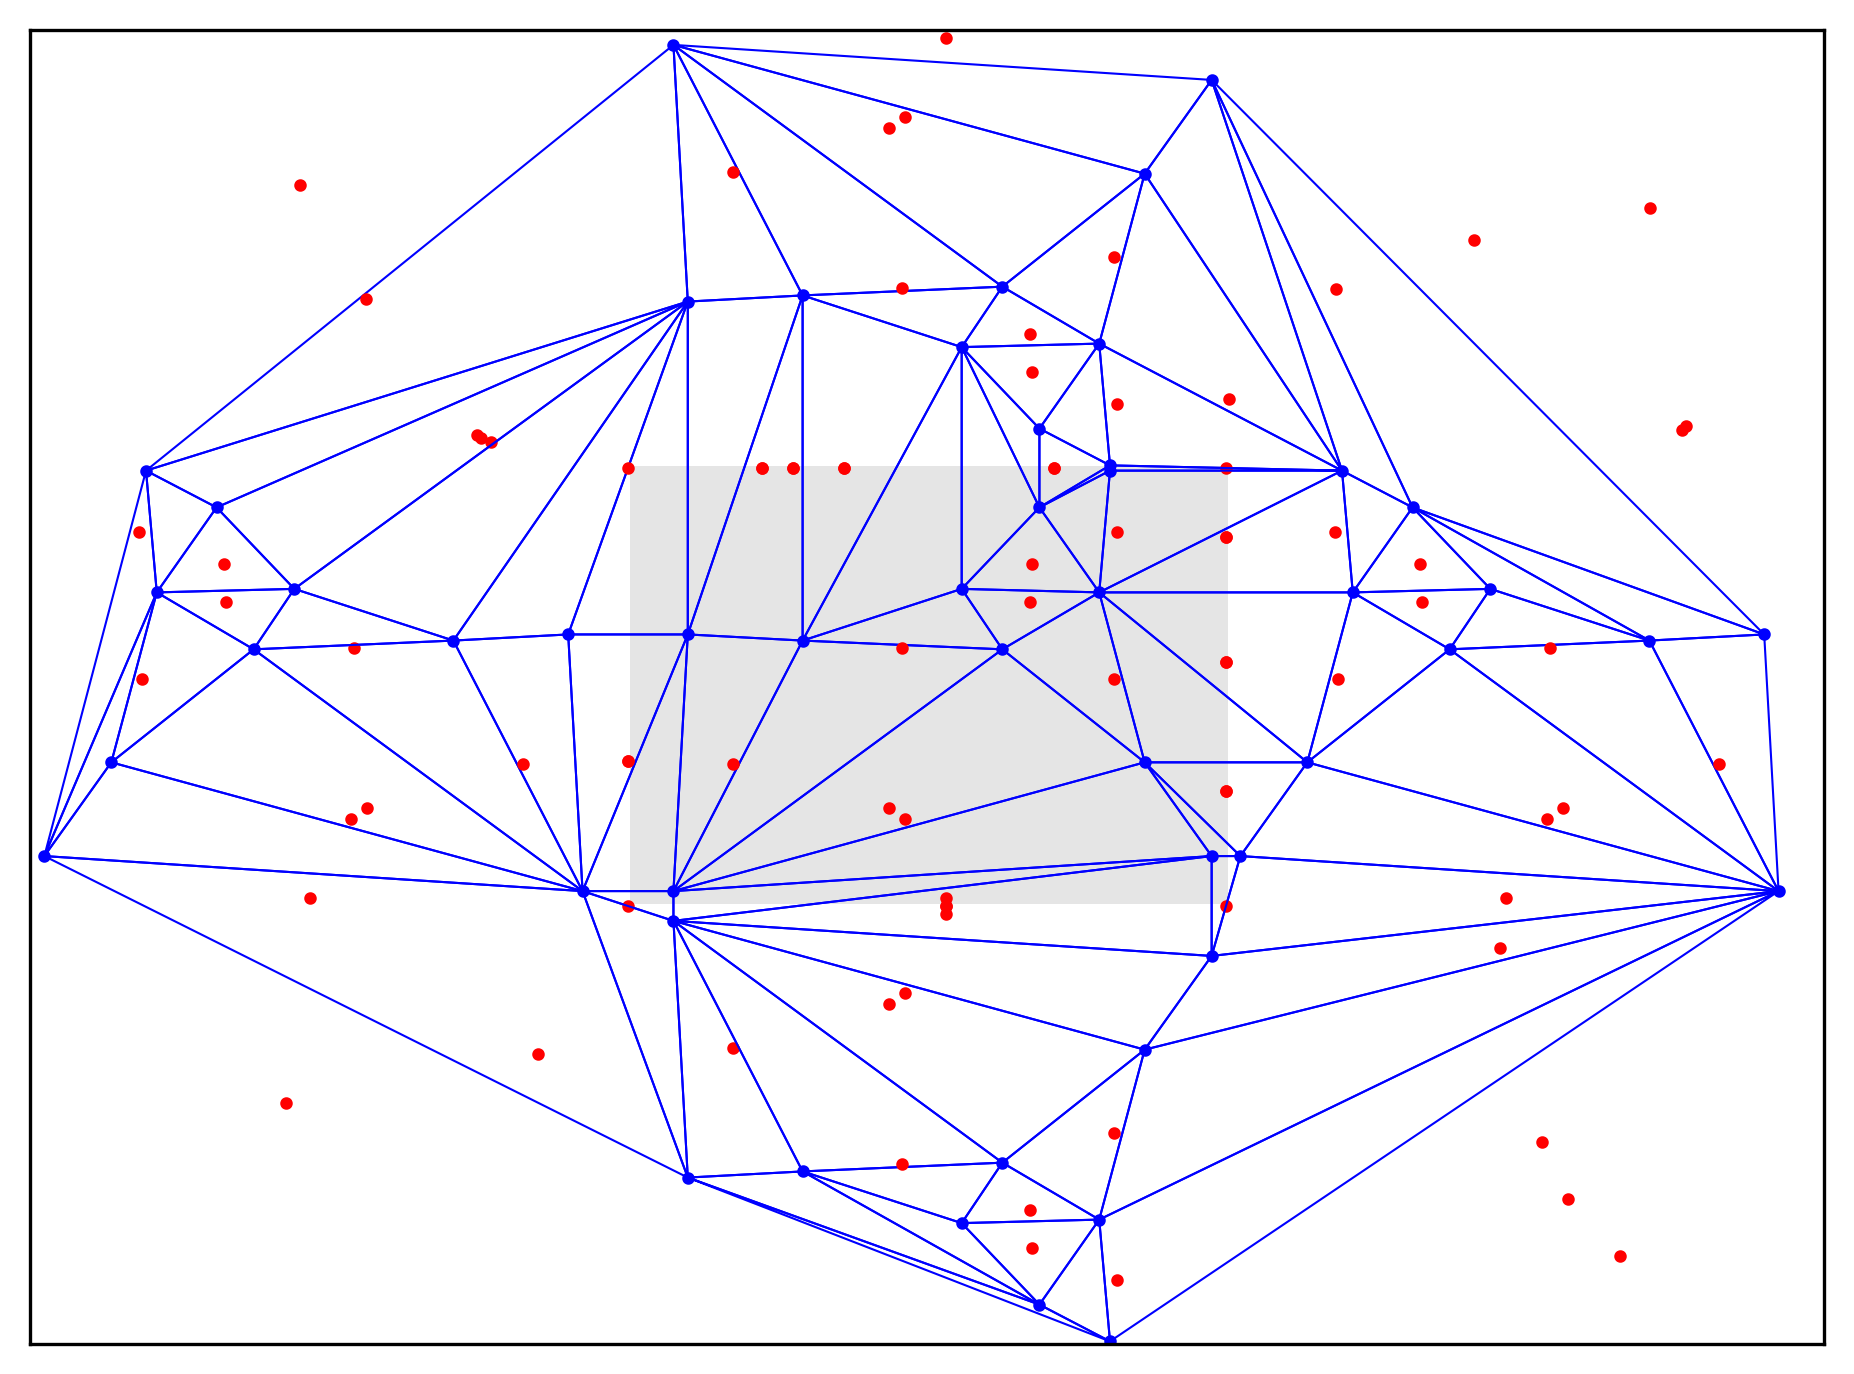

In [8]:
# First we can reflect our original dataset along the edges of the box
pts = points_xy
pts = np.tile(pts, (5,1,1))

pts[[1,2],:,1] *= -1
pts[[3,4],:,0] *= -1

pts[2,:,1] += 2*h
pts[4,:,0] += 2*w

mirrored = pts.reshape((5 * n ,2))

# Lift onto 3D paraboloid
points_xyz = lift_points(mirrored, np.zeros(n * 5))

# Calculate 3D convex hull
mhull = ConvexHull(points_xyz)
lowers = get_lower_facing(mhull)

# Grab the normal vectors of each face
eqns = (mhull.equations[lowers])

# Plot the circumcenter of each Delaunay triangle, including Voronoi cells from the old method to
# check our work

fig, ax = plt.subplots()

ax.set_ylim((-h,2*h))
ax.set_xlim((-w,2*w))

for i, s in enumerate(mhull.simplices[lowers]):
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    
    # Projecting these back to z=0 gives the Delaunay Triangulation
    ax.plot(points_xyz[s, 0], points_xyz[s, 1],  'b-', lw=0.5)
    
    # Get the weighted circumcenters from the convex hull
    verts = -0.5 * eqns[i, :2] / eqns[i, 2]
    ax.plot(verts[0], verts[1], 'ro')

ax.plot(points_xyz[:, 0], points_xyz[:, 1], 'bo')

# Draw the bounding box of the diagram
ax.add_patch(mpl.patches.Rectangle((2, 2), w, h, color='grey', alpha=.2, lw=0))
no_ticks(ax)

plt.show()

Now we have all the vertices bounded to our original box, all that's left is to define the Voronoi cells around each site.

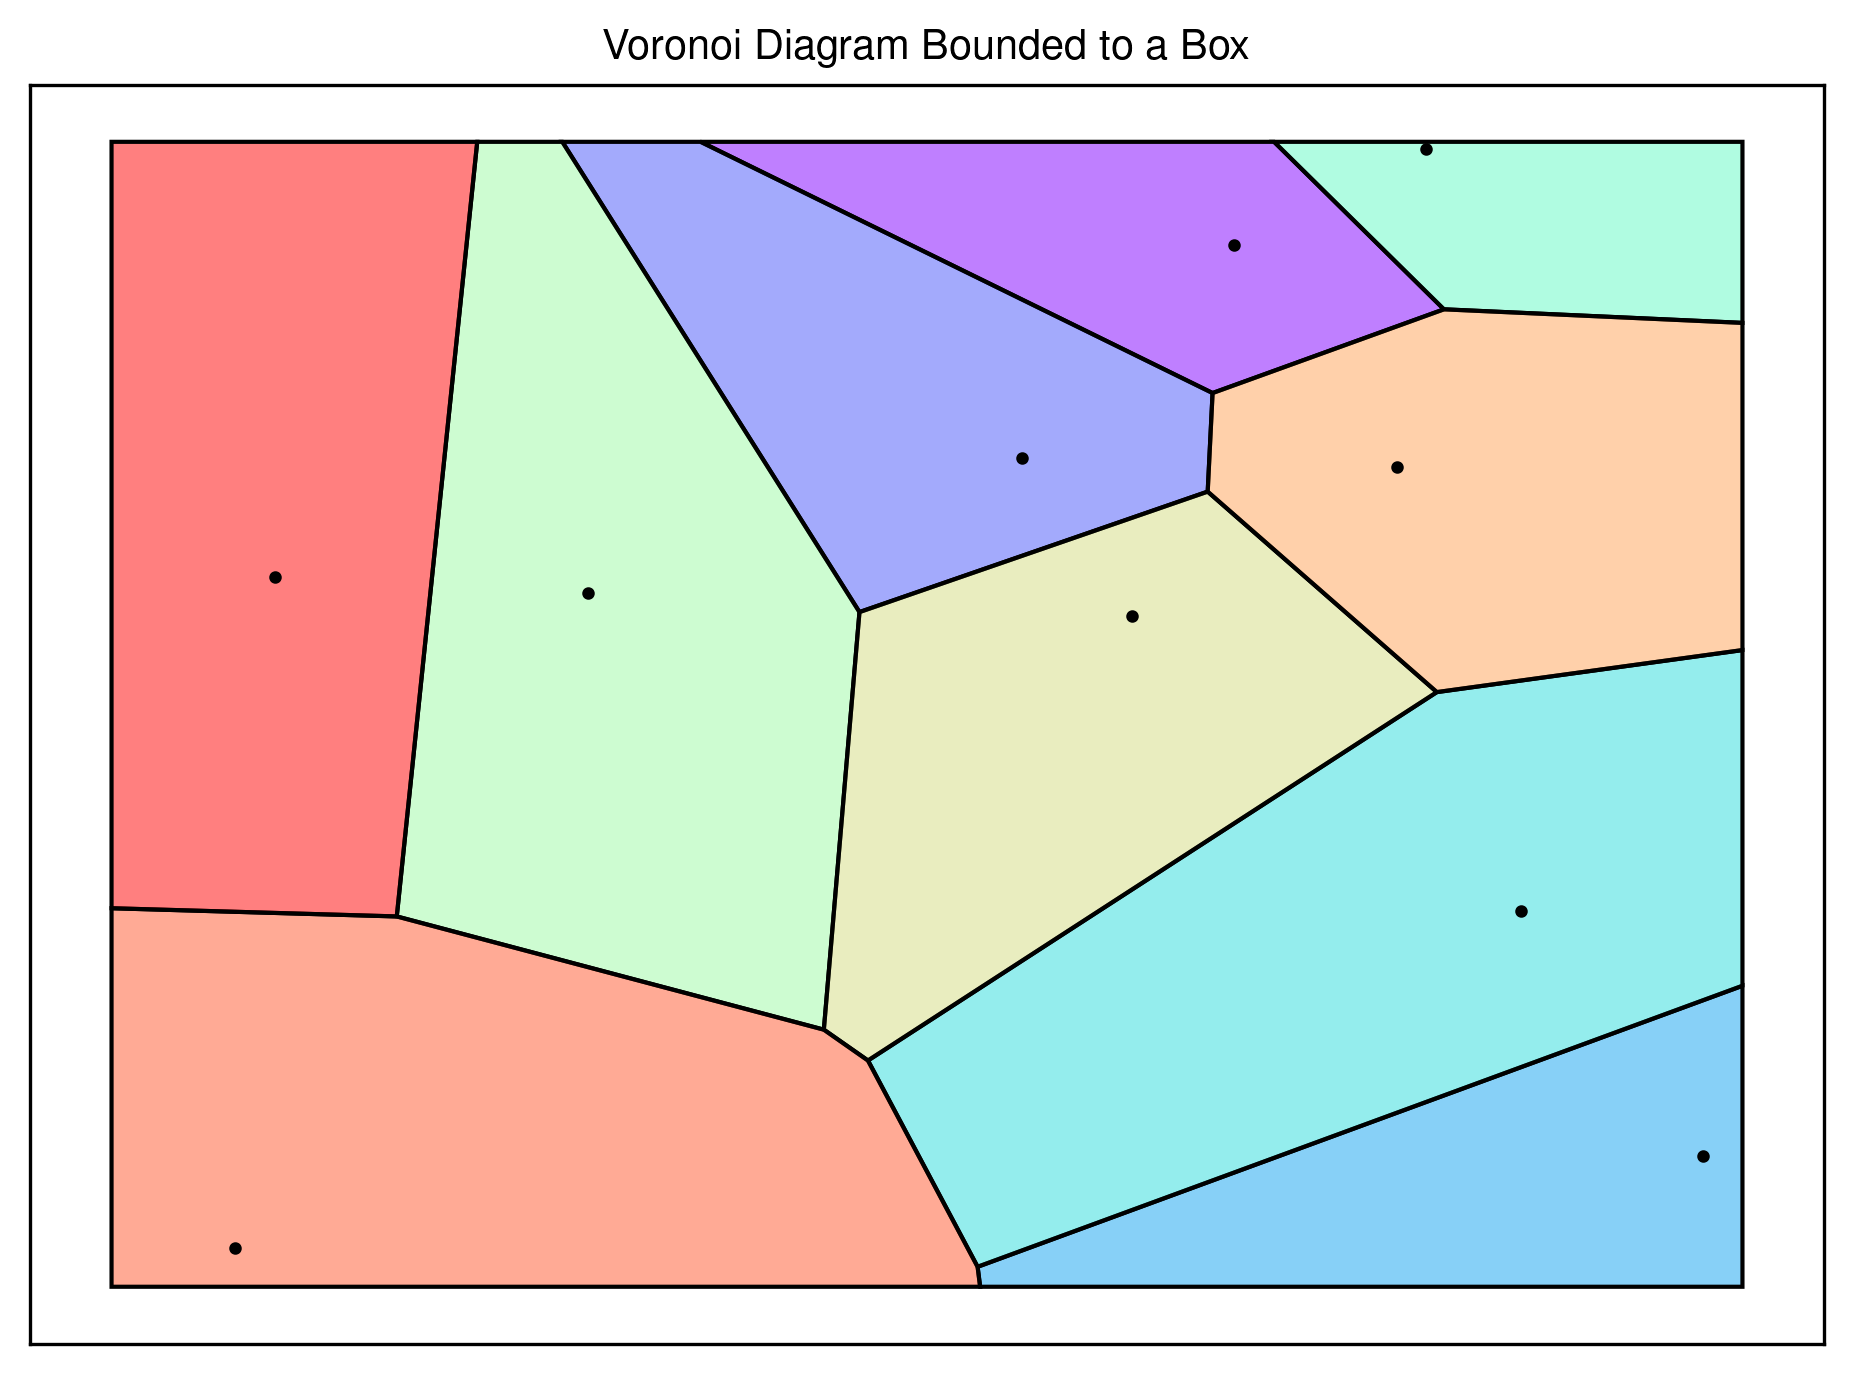

In [9]:
lowers = get_lower_facing(mhull)
triangles = mhull.simplices[lowers]
eqns = mhull.equations[lowers]

vertices = np.array([-0.5 * eq[:2] / eq[2] for eq in eqns])

fig, ax = plt.subplots()

colors = mpl.cm.get_cmap(name='rainbow')(np.linspace(0,1,n))

for i, site in enumerate(points_xy):

    # for each site, get the weighted circumcenters of all the delaunay triangles it belongs to
    
    # get the indices of all triangles that have point i as a vertex
    indices = np.where(triangles==i)[0]
    #print(f"i = {i}:\n{indices}")
    
    # Get all the vertices from the convex hull
    verts = vertices[indices]
    # Sort the vertices in clockwise order
    verts = np.array(sorted(verts,
                            key = lambda v: np.arctan2((v[1] - site[1]), (v[0] - site[0]))))
   
    ax.fill(verts[:,0], verts[:,1], 
            facecolor=mpl.colors.to_rgba(colors[i],0.5),
            edgecolor='black')

    ax.plot(site[0], site[1], 'ko')
ax.set_title('Voronoi Diagram Bounded to a Box')
no_ticks(ax)
plt.show()

Instead of mirroring our points to clip to the bounding box, which requires 5 times as many sites, we can be a little more intentional about the way we calculate the edges of the Delaunay triangulation and resulting Voronoi diagram so that these infinite edges are taken into account. 

If we can calculate the direction that the infinite edges are going, we can use the equation of that line to define a vertex at some distance away that is guaranteed to be outside our box. Then we can clip the cells that intersect the box using a well known polygon-clipping method called the Sutherland-Hodgman algorithm.

#### Infinite Edges

We need to take care of the edges of the Delaunay triangulation in order to have a full set of Voronoi cells in our final tesselation. The convex hull gives us infinite edges between a lower- and upper-facing face on the 3D convex hull. If we don't take care of these infinite edges, we won't be able to get all the vertices of the cells on the outside edges of the diagram. 

<p align="center"><img src="projection_infinite.png" alt="projection of the convex hull to form infinite edges in the Delaunay Triangulation" width="500"></p>

The projection of the upward-facing face gives us an open triangle (not really a triangle, I suppose), so the weighted circumcenter is infinite. We can clip these infinite vertices to the edges of the box we're interested in using some geometry.

Stand by while we rewrite all the methods for getting the edges of the Voronoi diagram from the convex hull:

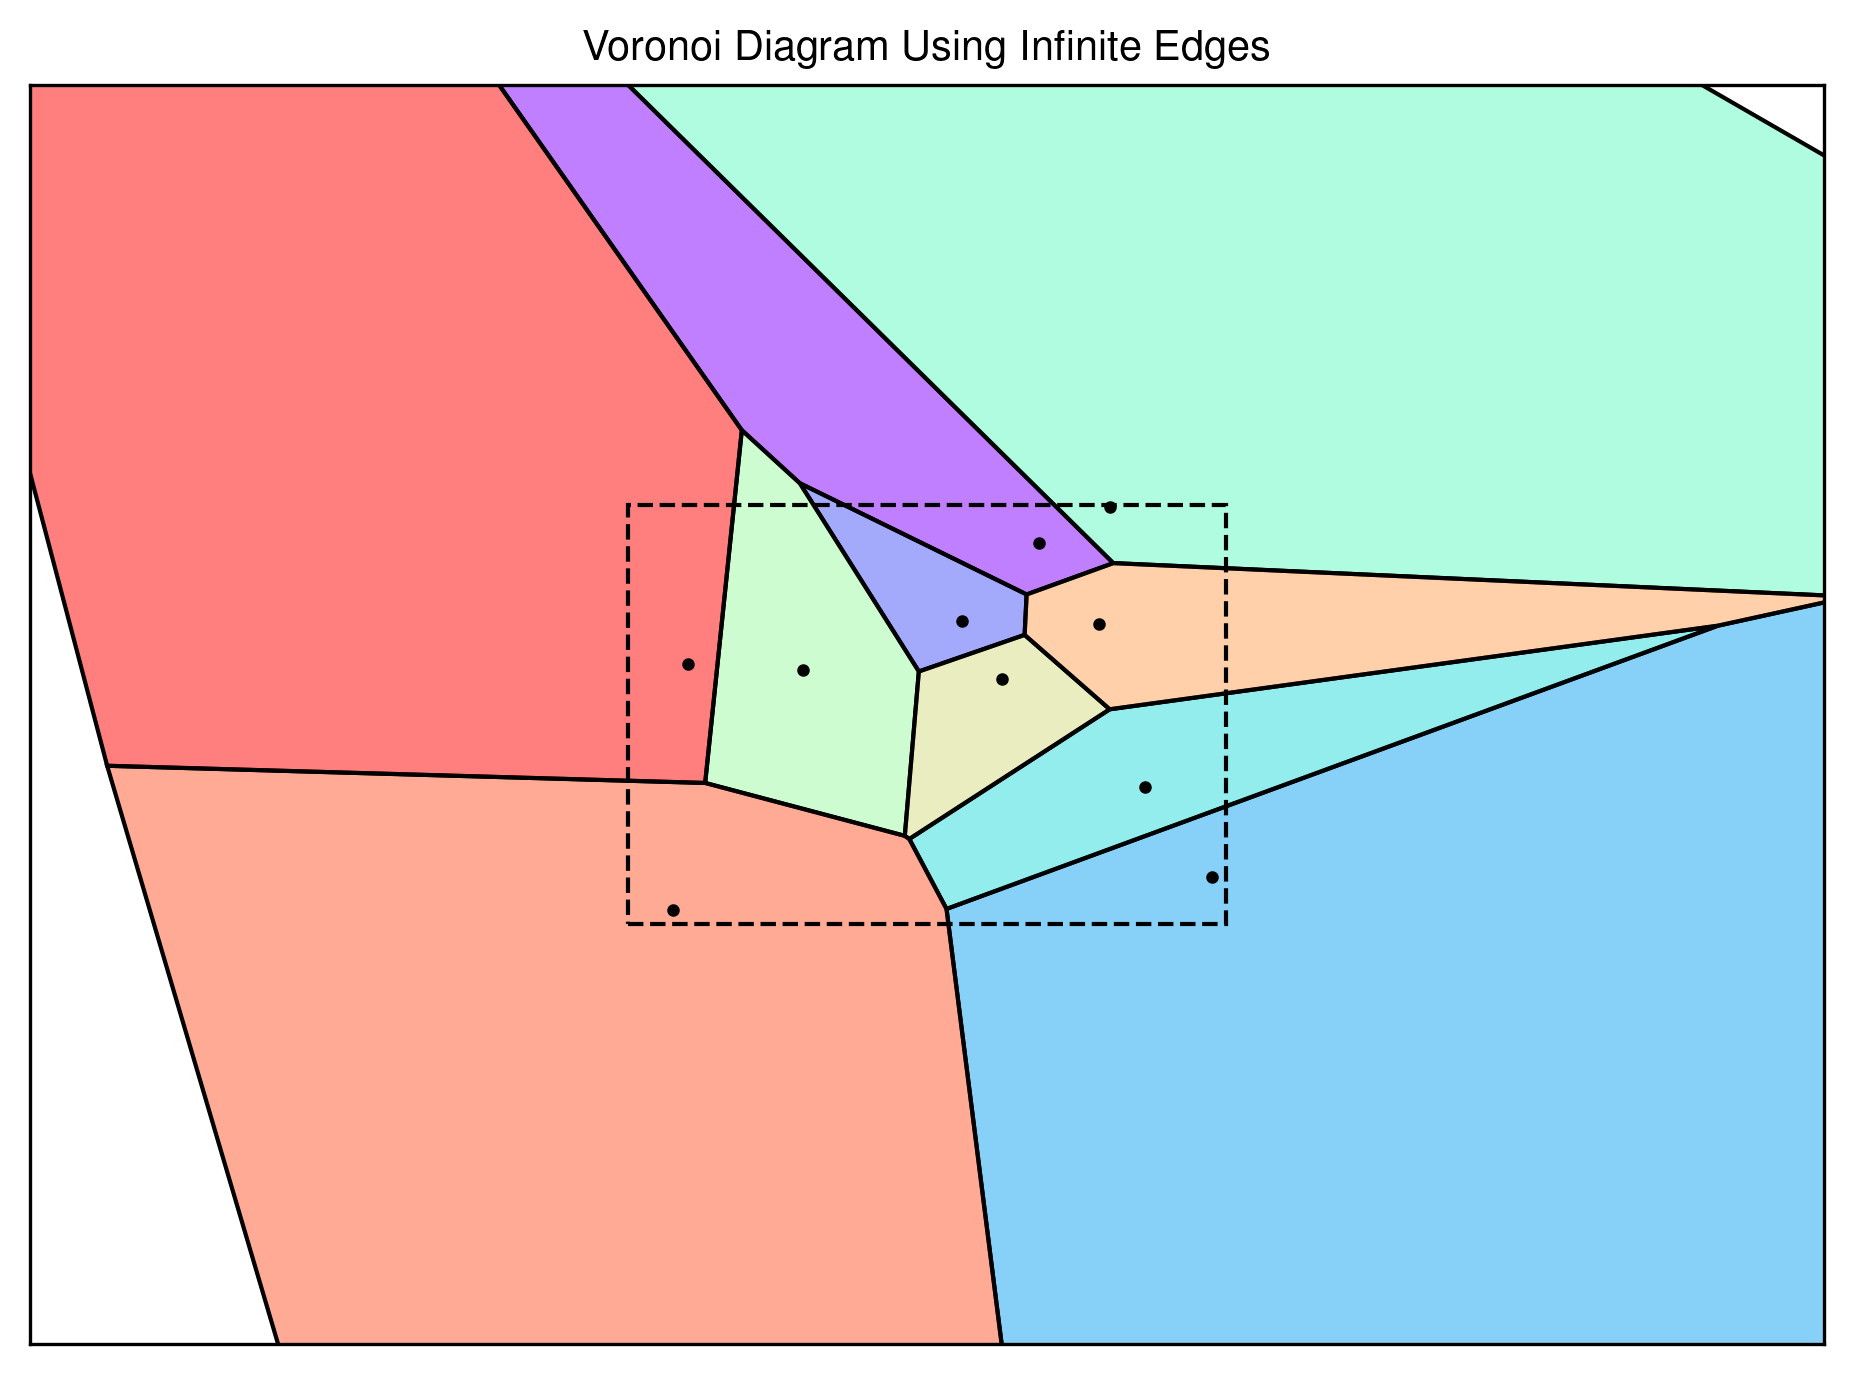

In [10]:
sites = points_xy

def get_delaunay_edges(hull, lowers):
    """ 
    Find all the edges in the Delaunay triangulation by grabbing all the pairs of faces in the convex hull that share an edge.
    If one of the faces in a pair is not downward-facing, the edge is infinite.
    Arguments:
        hull: scipy.ConvexHull object
        lowers: indices of the hull faces that are downward-facing (finite delaunay triangles)
    Returns:
        neighbors: array of pairs of hull face indices that are unique neighbors defining a delaunay edge
        infinite: boolean mask giving all the edges that are infinite
    """
    
    # the neighbors attribute contains the indices of the 3 faces that are the neighbors
    # of the face corresponding to each position in the array
    neighbors = np.zeros((lowers.shape[0], 2 * hull.ndim), dtype = int)
    
    # Each valid face has three edges that start at that faces index
    neighbors[:, 0::2] = lowers[:, None] # set every other element to the face index
    neighbors[:, 1::2] = hull.neighbors[lowers] # set the remaining elements to the neighbors' indices
    
    # Reshape array to be a list of pairs of indices (start and stop indices) defining an edge
    neighbors = np.sort(neighbors.reshape([-1,2]), axis = 1)
    # Remove any duplicate edges
    neighbors = np.unique(neighbors, axis = 0)
    
    # Make a mask of edges that are finite (connect faces that are both downward facing)
    infinite = np.isin(neighbors, lowers).sum(axis=1) != 2
    
    return neighbors, infinite

def get_vertices(hull):
    """
    Calculate the two vertices corresponding to each edge in the convex hull, i.e. the
    dual of the Delaunay triangulation.
    """
    # Get indices for faces of the hull that are downward facing (finite edges)
    lowers = get_lower_facing(hull)
    
    neighbors, infinite = get_delaunay_edges(hull, lowers)
    
    # Suppress divide by zero errors for this bit since there will be some infs
    old_settings = np.seterr(invalid = 'ignore', divide = 'ignore')
    # Calculate all the vertices from the hull equations
    vertices = -0.5 * hull.equations[:,:2] / hull.equations[:,2][:, None]
    
    # Get the vertices corresponding to each edge
    vertices = vertices[neighbors]
    
    # overwrite the infinite vertices to clip to the bounding box
    vertices[infinite] = [get_infinite_vertices(hull, edge, lowers) for edge in neighbors[infinite]]
    
    # Revert to the old error settings
    np.seterr(**old_settings)
        
    return vertices, neighbors

def get_infinite_vertices(hull, edge, lowers):
    """
    Calculate the dual vertices when one of the faces defining the edge is not downward-facing
    """
    # Determine which face defining the edge is the nasty one
    is_lower = np.isin(edge, lowers)
    f1, f2 = edge[is_lower], edge[~is_lower]

    # Check that only one face is bad
    if np.sum(is_lower) != 1:
        print("An edge is only infinite if one of the two faces is nasty.")
        return
    
    # Get the two vertices the faces have in common
    triangle = hull.simplices[f1]
    verts = np.intersect1d(triangle, hull.simplices[f2])
    p1, p2 = hull.points[verts[0]], hull.points[verts[1]] # vertices in form [x y z]
    edge = np.stack((p1[:2],p2[:2]))
    
    # get the one point in the triangle f1 that isn't on the shared edge
    p3 = hull.points[triangle[~np.isin(triangle, verts)]][0, :2]
    
    # the dual vertex of the lower-facing plane is calculated normally
    v1 = (-0.5 * hull.equations[f1, :2] / hull.equations[f1, 2])[0]
    
    # Calculate another point on the line to define the infinite edge
    # Calculate the slope of the line perpendicular to the line connecting p1 and p2
    m = -(p2 - p1)[0] / (p2 - p1)[1]
    dx = w #- v1[0]
    dy = m * dx
    delta = np.array([dx, dy])
   
    if np.dot(delta, np.mean(edge, axis=0) - p3) < 0:
        # if delta is pointing towards p3, flip it around
        delta *= -1
    
    v2 = v1 + delta

    return np.stack((v1, v2))

def get_cells(hull):
    """
    Get the indices of the edges corresponding to each site
    """
    sites = hull.points
    vertices, neighbors = get_vertices(hull)
    triangles = hull.simplices[neighbors] # get the indices of the vertices for each face
    # Find the common edge between each pair of neighboring triangles
    edge_sites = np.array([np.intersect1d(pair[0], pair[1]) for pair in triangles])
    
    # Get all the edges containing each vertex
    cells = []
    cell_vertices = []
    for i, site in enumerate(sites):
        # get the indices of the edges containing each site
        edge_idx = np.argwhere(edge_sites == i)[:,0]
        cells.append(edge_idx)
        verts = vertices[edge_idx]
        # remove duplicate vertices
        verts = np.unique(np.reshape(verts, (-1,2)), axis = 0)
        
        # Sort the vertices in clockwise order
        verts = np.array(sorted(verts,
                                key = lambda v: np.arctan2((v[0] - site[0]), (v[1] - site[1]))))

        cell_vertices.append(verts)
    
    return cell_vertices

# Define the bounding box
box = np.array([[0,0],[0,h],[w,h],[w, 0]], dtype=float)

fig, ax = plt.subplots()

# Get all the cell vertices from the Convex Hull
cells = get_cells(hull)

colors = mpl.cm.get_cmap(name='rainbow')(np.linspace(0,1,n))
for i, cell in enumerate(cells):
    
    # Plot the cell before clipping to the boundaries
    ax.fill(cell[:,0], cell[:,1],
            facecolor=mpl.colors.to_rgba(colors[i],0.5), edgecolor='black')
    
"""# Check that the vertices are sorted in clockwise order
cell = cells[7]
for i, vert in enumerate(cell):
    label = i+1
    ax.annotate(label, (vert[0], vert[1]),
                textcoords = "offset points",
                xytext = (5,5),
                ha = 'center', size = 8)

    ax.plot(vert[0], vert[1], 'ro')"""

# Plot the original sites
ax.plot(sites[:,0], sites[:,1], 'ko')

# Show the bounding box
ax.add_patch(plt.Rectangle((0,0),w,h, color='k', ls='--', fill=False))

#ax.set_xlim(-.5*w,1.5*w)
#ax.set_ylim(-.5*h,1.5*h)
ax.set_xlim(-w,2*w)
ax.set_ylim(-h,2*h)

no_ticks(ax)
ax.set_title(f"Voronoi Diagram Using Infinite Edges")
#plt.savefig('clipping_infinite_edges.png')

plt.show()

### Sutherland-Hodgman Algorithm

The Sutherland-Hodgman algorithm is a well-known polygon clipping method that only requires ther *vertices* of each polygon rather than the *edges*, so it's perfect for the data structure we've been using so far.

This algorithm takes the vertices in clockwise order and looks at one edge (two consecutive vertices) at a time. For each edge there are four possibilities:

1. **Both vertices are inside:** Add the second vertex to the output list
2. **First vertex is outside, second is inside:** Add the second vertex to the output list, as well as the intersection of the boundary and the edge.
3. **First vertex is inside, second is outside:** Add the intersection of the boundary and the edge to the output list
4. **Both vertices are outside:** Move on

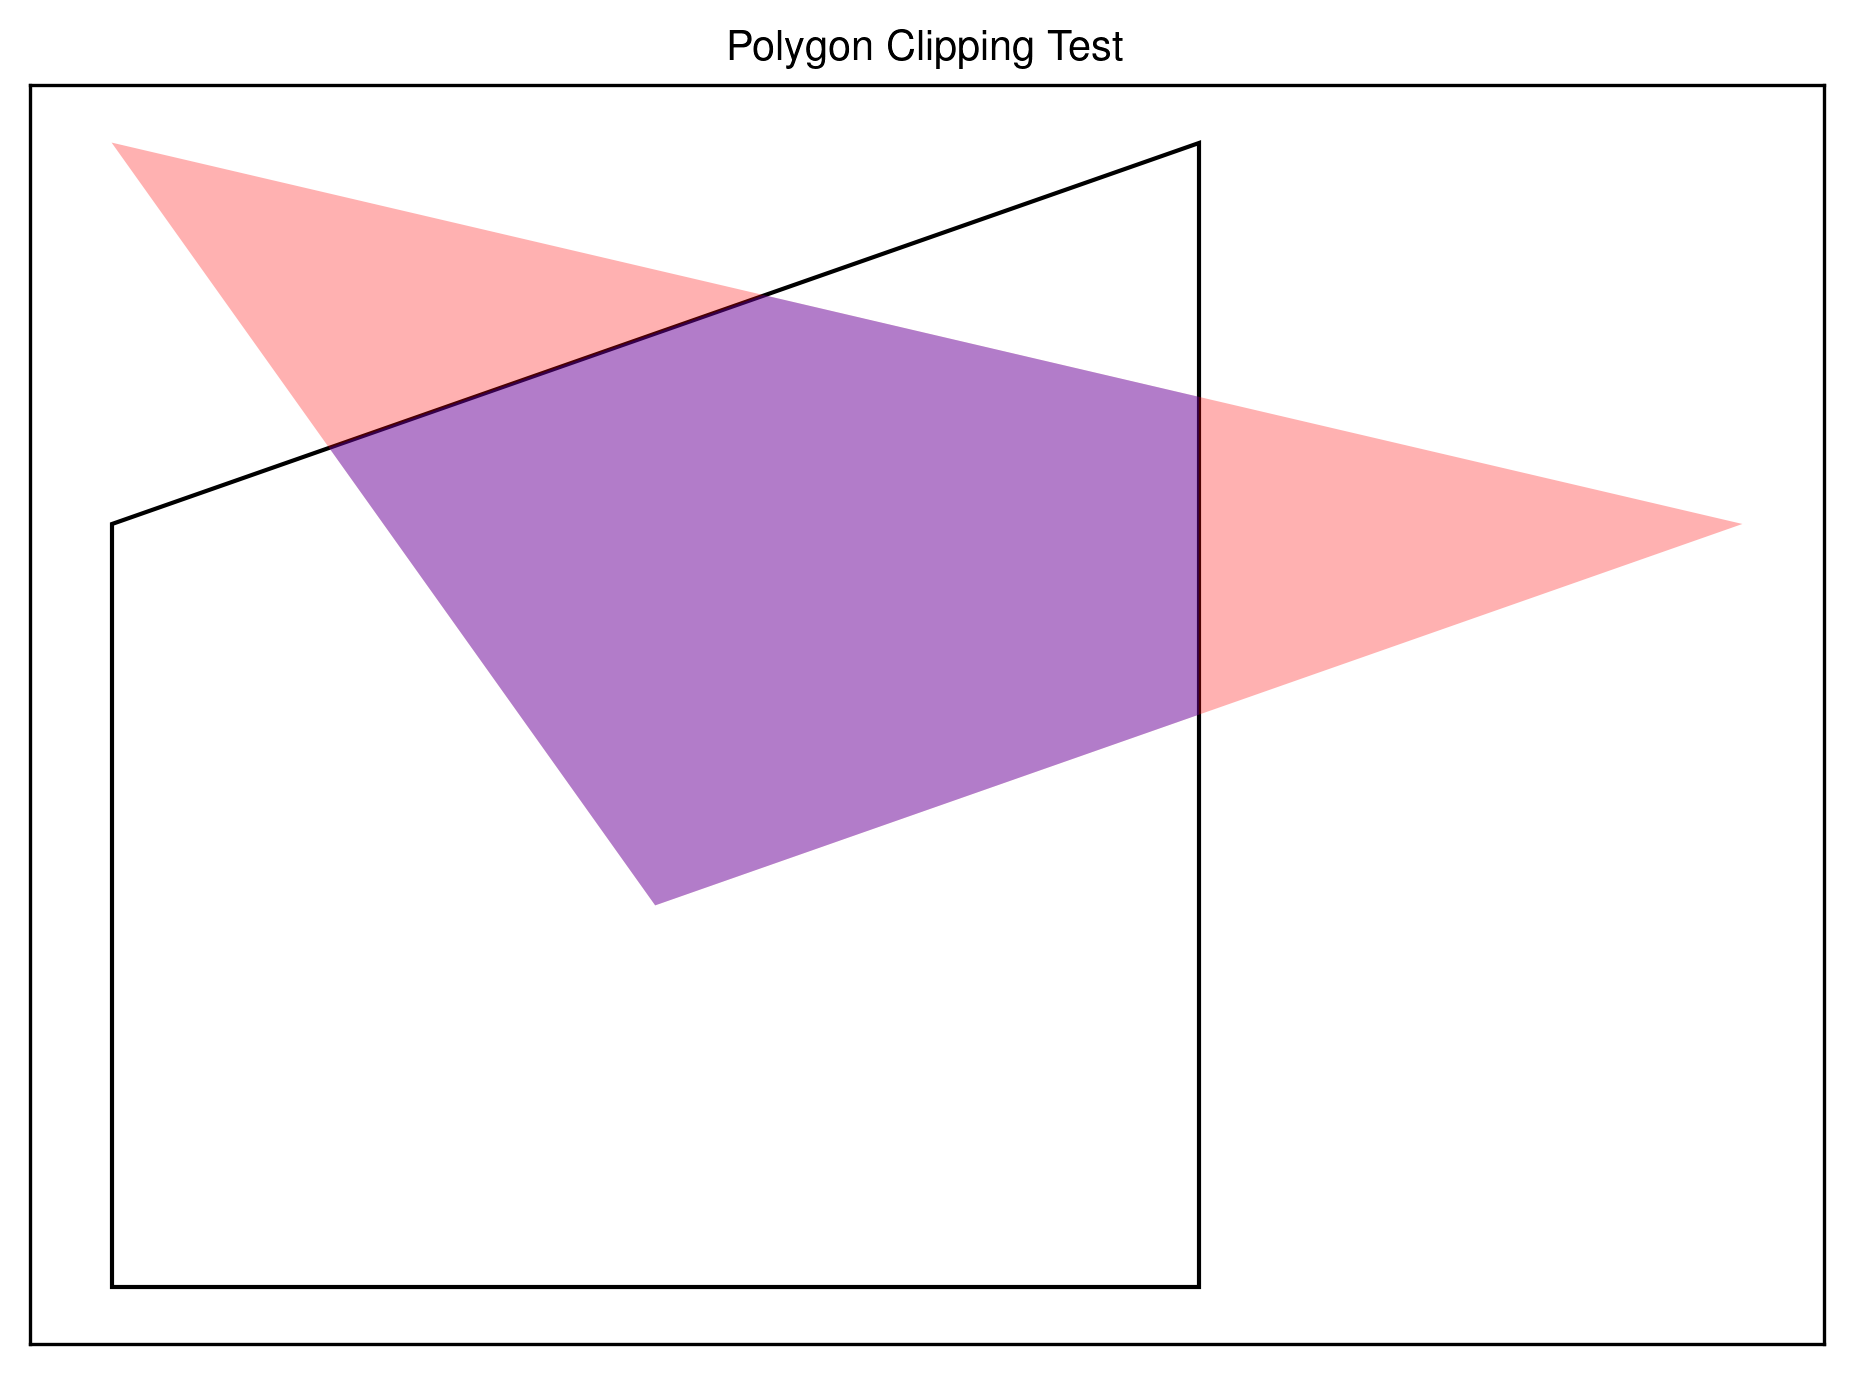

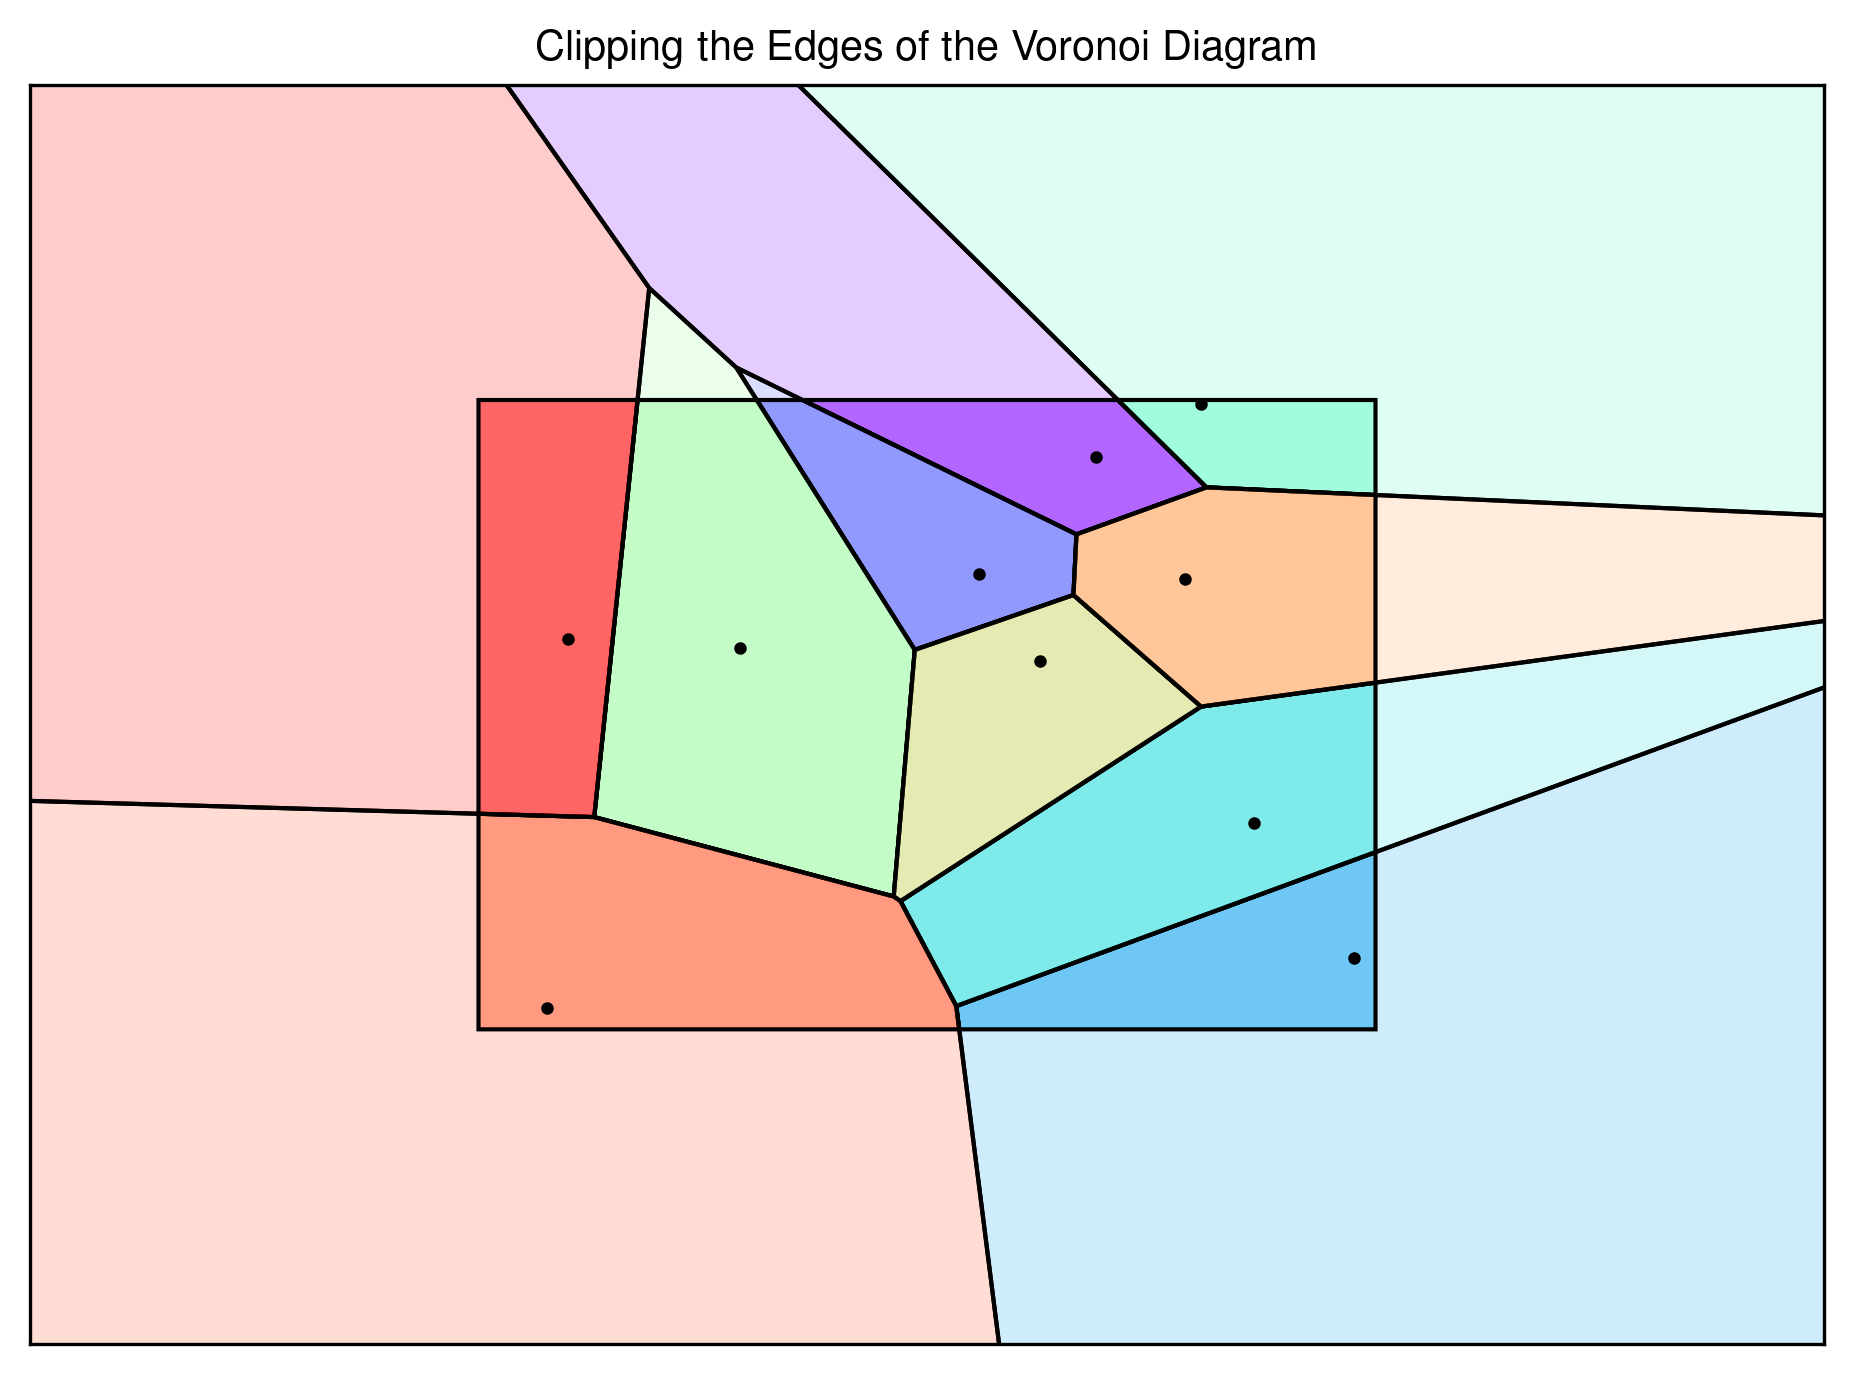

In [11]:
def inside(point, line):
    """
    Determine if a point is on the right side of a line
    
    When going clockwise, being on the right side of an edge means 
    the point is inside the box
    Arguments:
        point:  numpy array in format [x, y]
        line:   numpy array in format [[x1,y1],[x2,y2]]
                where the line starts at (x1,y1) and ends at (x2,y2)
    Returns:
        True if point is on or to the right of line, else False
    """
    P = np.flip(np.diff(line, axis=0)[0]) # gives [(y2-y1),(x2-x1)]
    P *= point - line[0] # gives [(y2-y1)(x - x1), (x2-x1)(y-y1)]
    P = np.diff(P)[0]
    return P <= 0

def get_intersect(line1, line2):
    """
    Determine the coordinates of the intersection between two lines
    by projecting into 3D space and taking the cross product
    Arguments:
        line1, line2:   numpy arrays in format [[x1,y1],[x2,y2]]
    Returns:
        P:  intersection point in format [x,y]
    """
    # get the equation of each line from the cross product of two points
    # line t = p1 x p2 must pass through both p1 and p2
    # since t . p1 = (p1 x p2) . p1 = 0
    points = np.vstack((line1, line2))
    
    # Add a third homogeneous coordinate
    points_3D = np.hstack((points, np.ones((4,1))))
    
    # Get vectors representing each line
    l1 = np.cross(points_3D[0], points_3D[1])
    l2 = np.cross(points_3D[2], points_3D[3])
    
    # Get the intersection of the two lines
    x,y,z = np.cross(l1, l2)
    
    if z == 0:
        return np.array([float('inf'), float('inf')])
    return np.array([x / z, y / z])

def clip(boundary, polygon):
    """
    Clip a polygon defined by its vertices to the given bounding box
    Arguments:
        boundary:   numpy array of the vertices of the bounding polygon to clip to,
                    given in clockwise order
        polygon:    numpy array of the vertices of the polygon to be clipped,
                    given in clockwise order
        
    """
    clipped = polygon.copy()
    
    box_edges = np.stack((boundary, np.roll(boundary, -1, axis=0)), axis =1)
    shape_edges = np.stack((polygon, np.roll(polygon, -1, axis=0)), axis =1)

    for box_edge in box_edges:
        edge_clipped = []
        for i, v1 in enumerate(clipped):
            v2 = clipped[i-1]
            is_inside = [inside(v1, box_edge), inside(v2, box_edge)]
            
            # if both vertices are outside, move along
            if np.all(is_inside):
                # Both vertices are inside the box, add the second vertex to final shape
                edge_clipped.append(v2)
                continue
            elif is_inside[0]:
                # Only the first vertex is inside, add the intersect to final shape
                edge_clipped.append(get_intersect(np.array([v1, v2]), box_edge))
                continue
            elif is_inside[1]:
                # Only the second vertex is inside, add both the second vertex and
                # the intersect to the final shape
                edge_clipped.append(v2)
                edge_clipped.append(get_intersect(np.array([v1, v2]), box_edge))
        edge_clipped = np.array(edge_clipped)
        # update the polygon after clipping to each edge
        clipped = edge_clipped
    return clipped


# Test the clipping algorithm
box = np.array([[2,3],[2,0],[0,0],[0,2]], dtype=float)
shape = np.array([[1,1],[0,3],[3, 2]], dtype=float)

fig, ax = plt.subplots()
ax.fill(box[:,0], box[:,1], facecolor = (0,0,0,0), edgecolor='black')
ax.fill(shape[:,0], shape[:,1], facecolor = 'red', alpha=.3)

new_shape = clip(box, shape)
ax.fill(new_shape[:,0], new_shape[:,1], facecolor = 'blue', alpha=.3)
no_ticks(ax)
ax.set_title(f"Polygon Clipping Test")

plt.show()


# Plot the clipped Voronoi diagram
fig, ax = plt.subplots()

# Define the edges of the box in clockwise order
box = np.array([[w,h],[w,0],[0,0],[0,h]], dtype=float)

for i, cell in enumerate(cells):
    
    # Plot the cell before clipping to the boundaries
    ax.fill(cell[:,0], cell[:,1],
            facecolor=mpl.colors.to_rgba(colors[i],0.2), edgecolor='black')
    # Clip the cell to the boundary and plot
    new_shape = clip(box, cell)
    ax.fill(new_shape[:,0], new_shape[:,1],
        facecolor=mpl.colors.to_rgba(colors[i],0.5), edgecolor='black')

# Plot the original sites
ax.plot(sites[:,0], sites[:,1], 'ko')

ax.set_xlim(-.5*w,1.5*w)
ax.set_ylim(-.5*h,1.5*h)

no_ticks(ax)
ax.set_title(f"Clipping the Edges of the Voronoi Diagram")
#plt.savefig('clipping_infinite_edges.png')

plt.show()

### Putting it all together

Now we can package all of these functions into a class for power diagrams, stored in <code>tesselate.py</code>. Putting this calculation into a class also lets us save certain attributes for each instance of the class rather than repeating any calculations that we've already done.

First let's double check that the this class is working as intended:

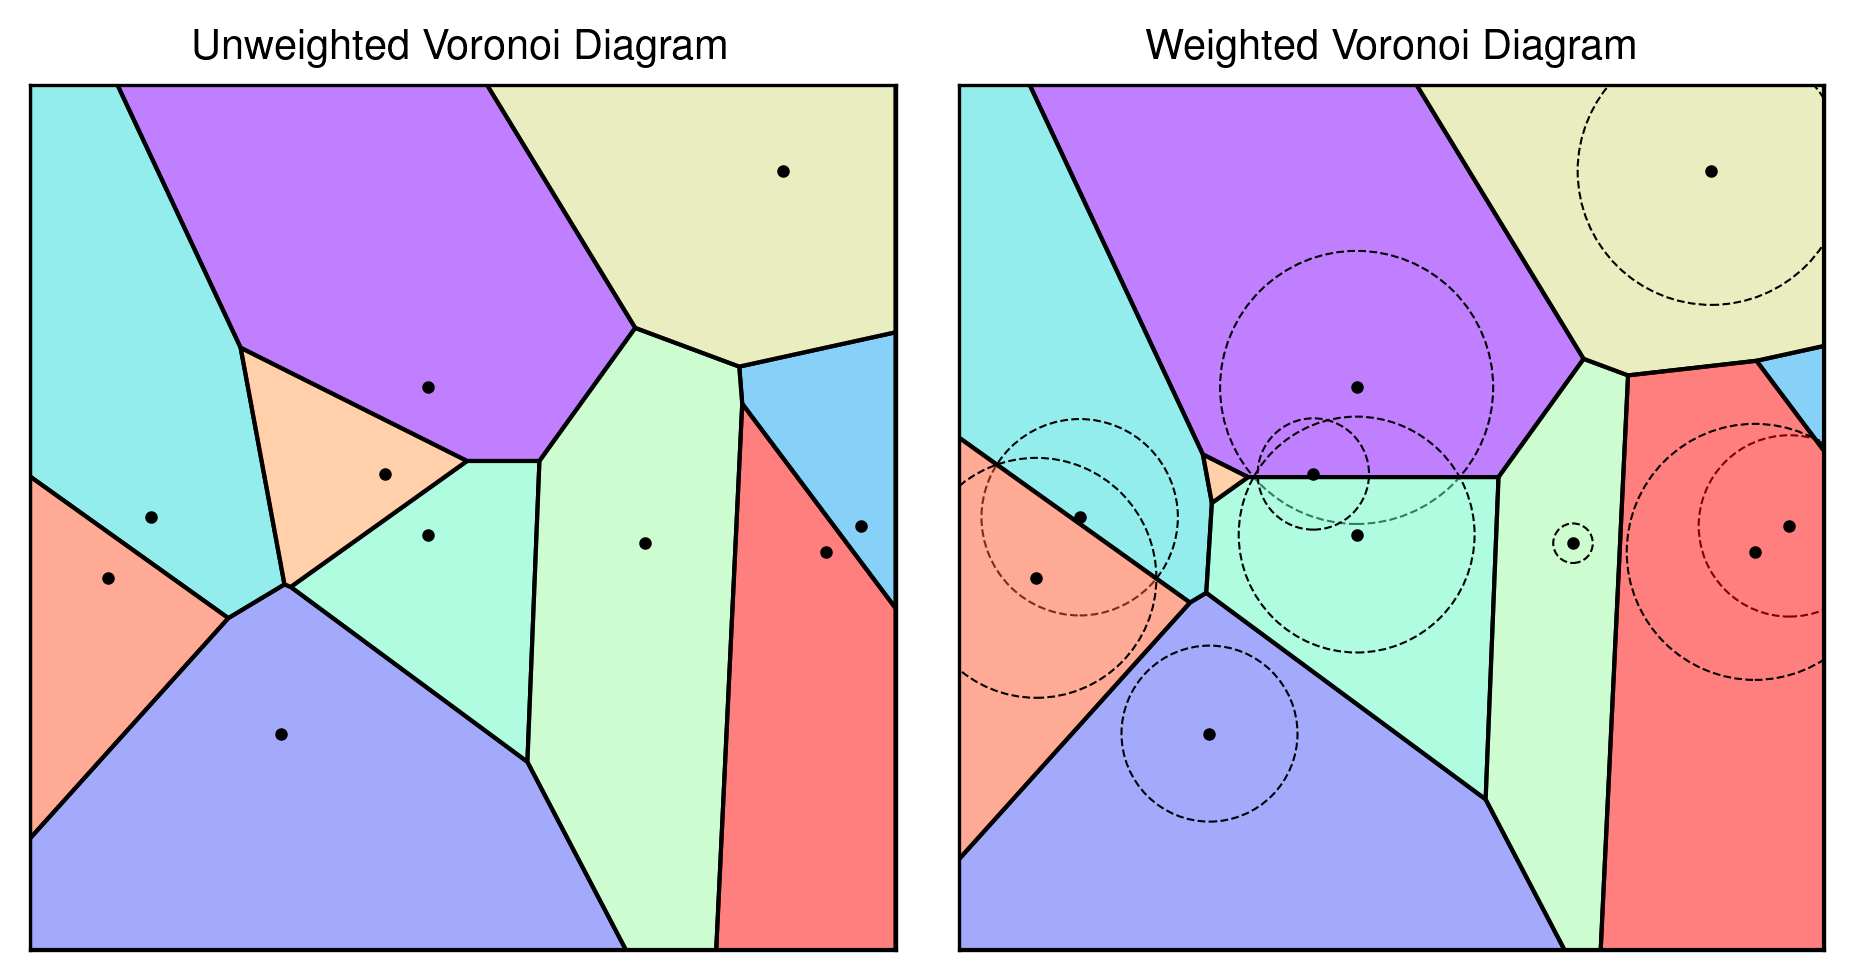

In [12]:
h, w = 100,100
N = 10

X, Y = np.indices((h,w))
weights = np.random.rand(N) * 250

# Randomly pick an index
idx = np.arange(X.size)
rand_idx = np.random.choice(idx, N, replace = False)

# Get the coordinates of each sampled point
pts = np.array([X.flatten()[rand_idx], Y.flatten()[rand_idx]], dtype=float).T

# Calculate the unweighted Voronoi
unweighted = tess.Voronoi(pts, (h, w))
# Calculate the weighted Voronoi
weighted = tess.Voronoi(pts, (h,w), weights)

fig, (ax1, ax2) = plt.subplots(1,2)

unweighted.plot(ax=ax1)
weighted.plot(ax=ax2, plot_weights = True)

ax1.set_title('Unweighted Voronoi Diagram')
ax2.set_title('Weighted Voronoi Diagram')

plt.show()

All Centroids within 1.0% after 12 iterations of Lloyd relaxation


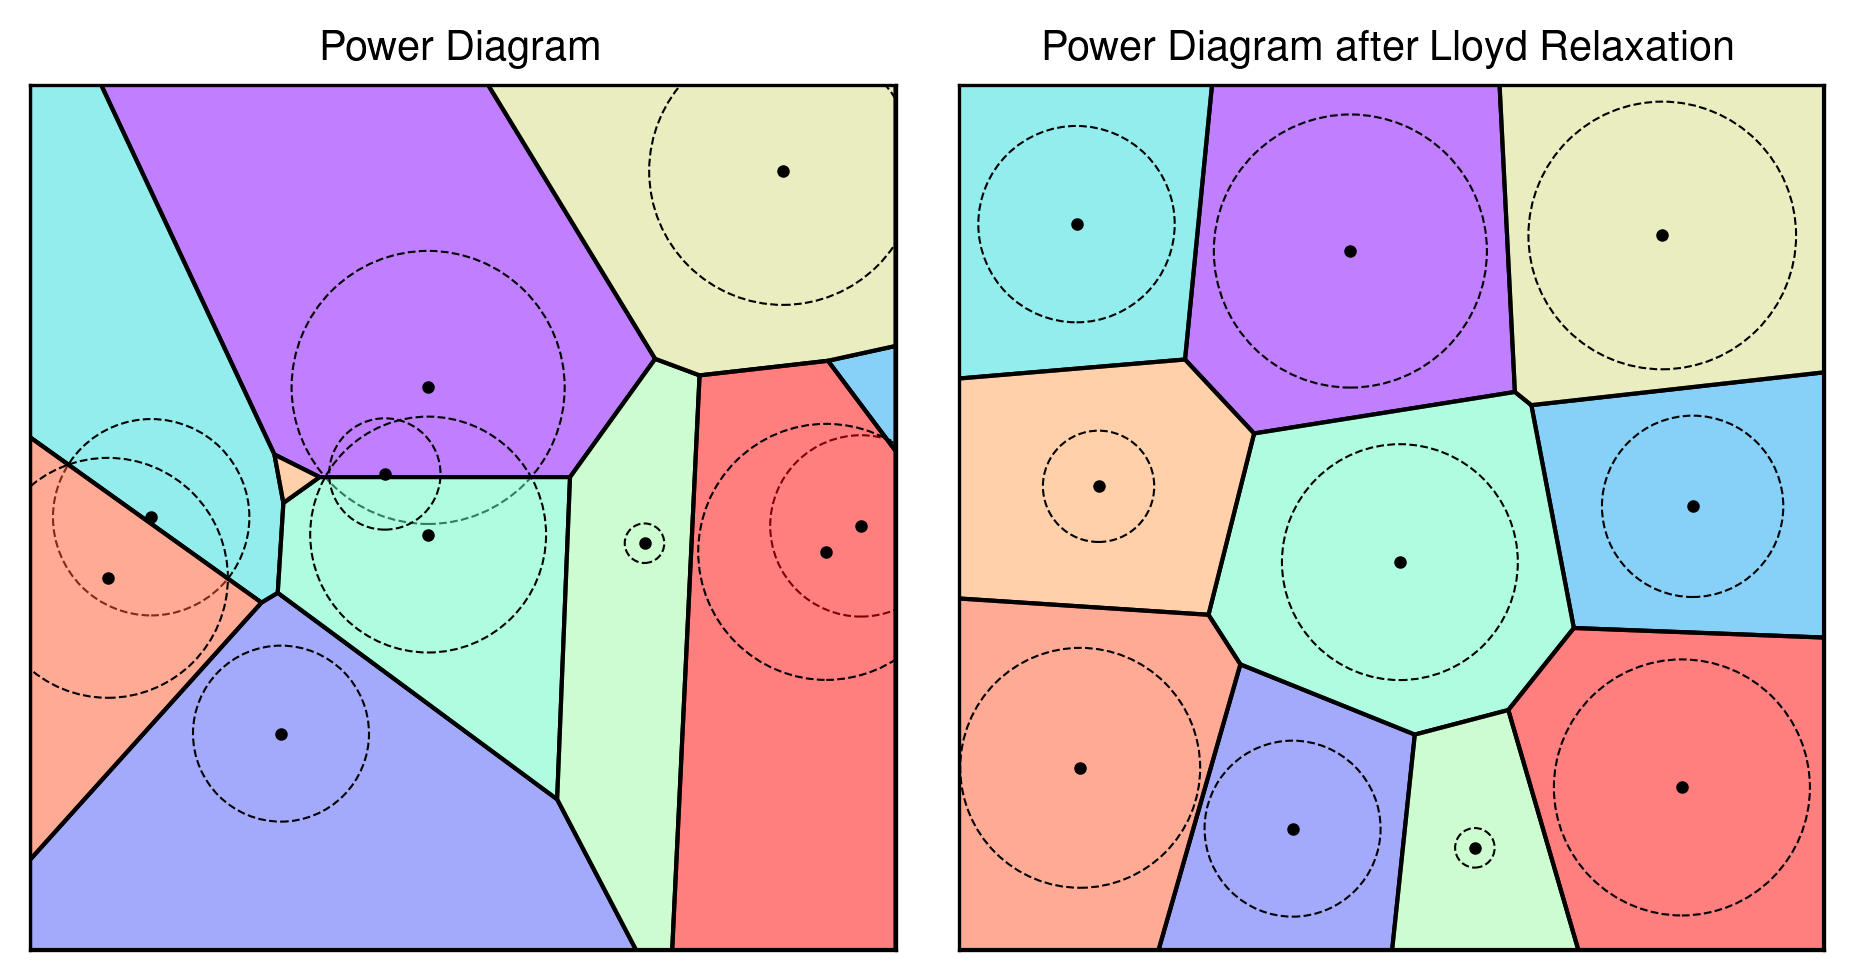

In [13]:
# Test out Lloyd relaxation

vor = tess.Voronoi(pts, (h, w), weights)

fig, (ax1, ax2) = plt.subplots(1,2)
vor.plot(ax=ax1, plot_weights=True)

vor.lloyd(threshold=0.01)
vor.plot(ax=ax2, plot_weights=True)
ax2.set_title("Power Diagram after Lloyd Relaxation")
plt.show()

## 2. Importance Sampling

Now that we have these algorithms under our belt, we can start working on calculating deflections in shadowgraphy images.

First thing's first we'll make some simple test images to use while developing this method.

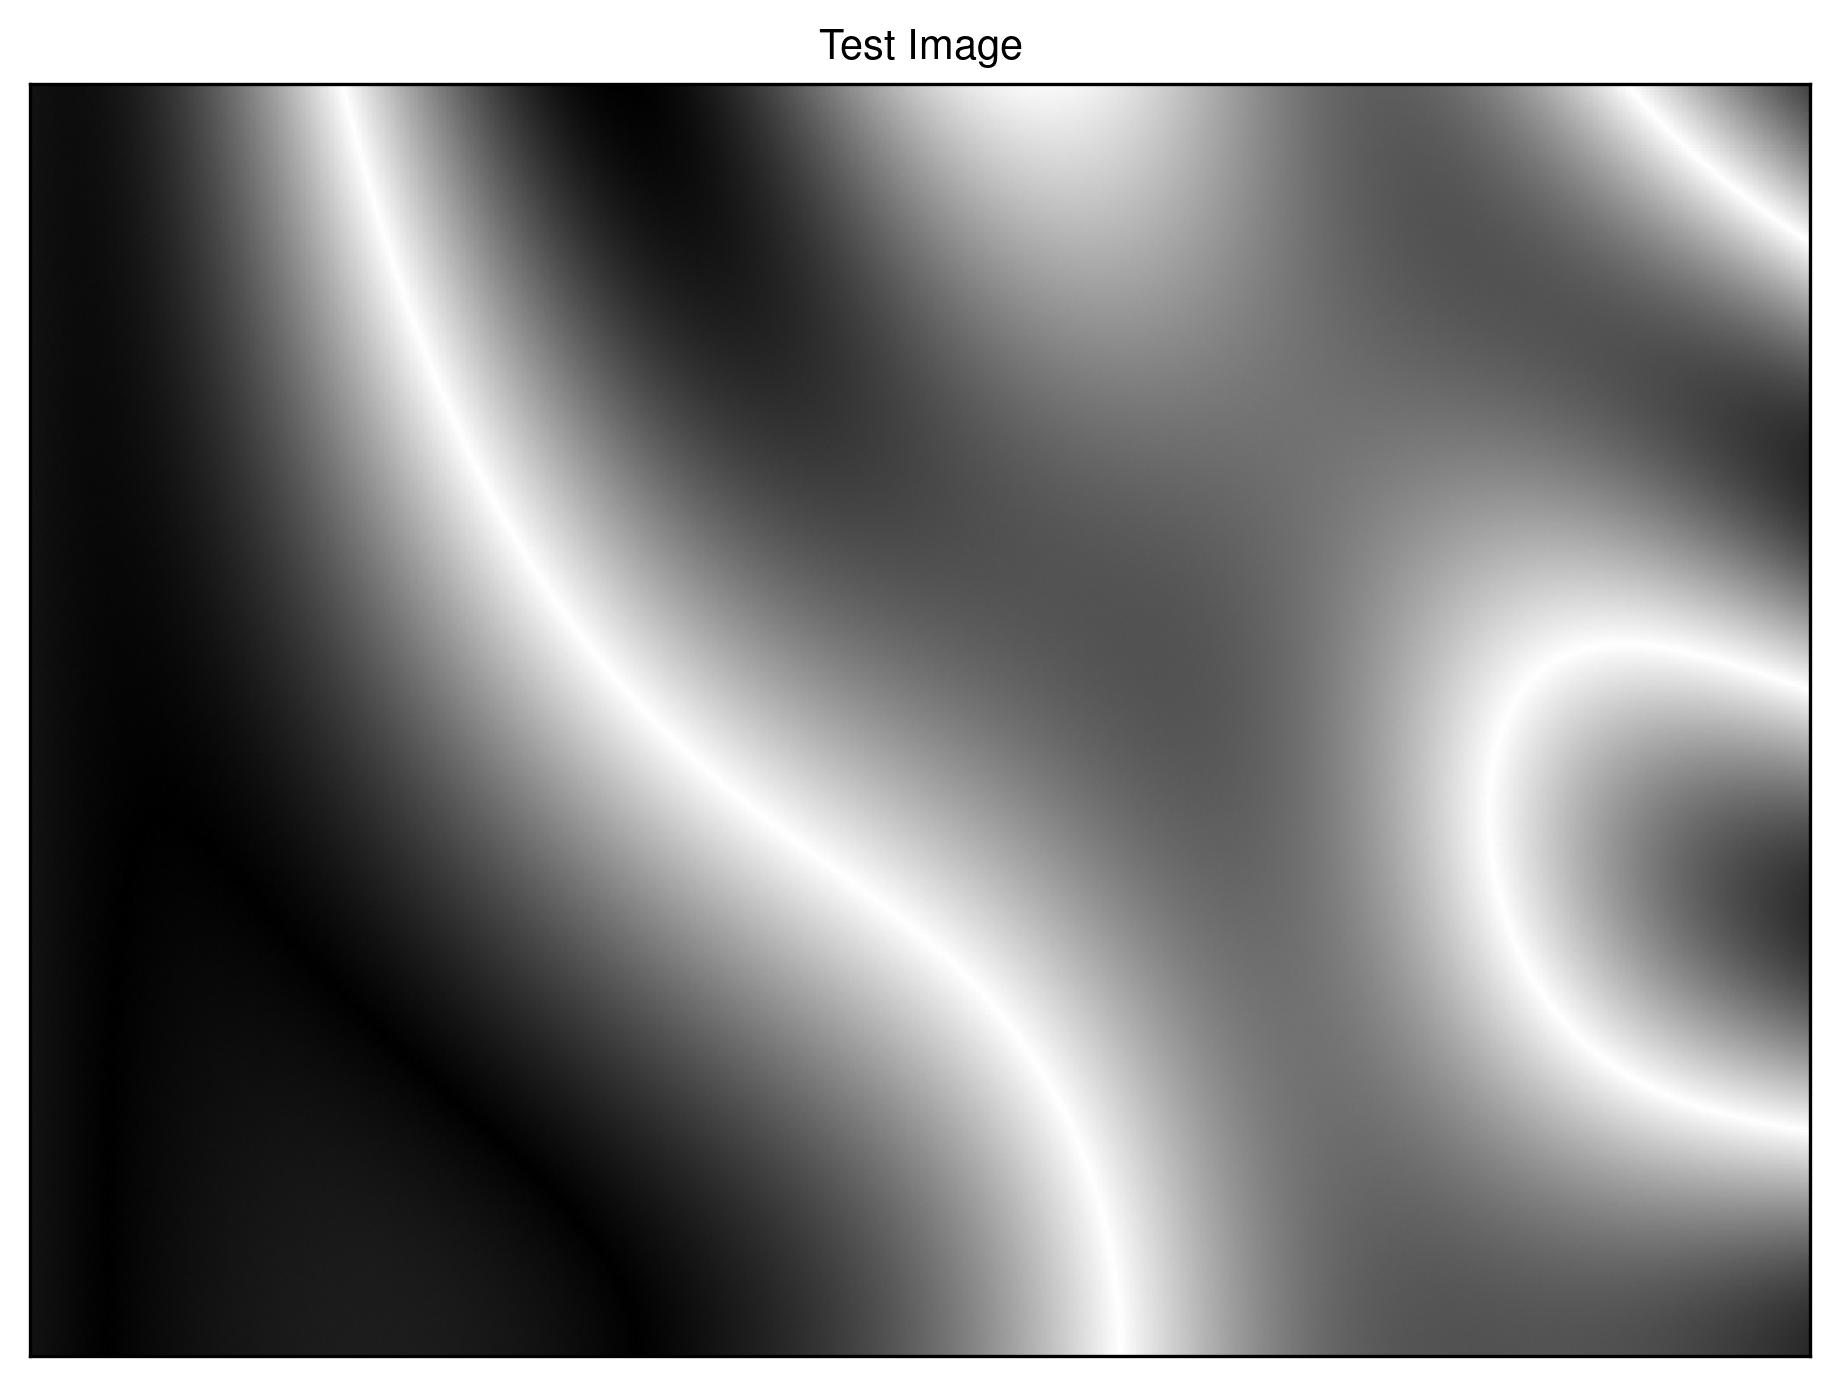

In [14]:
# Generate some funky test data
h, w = 500,700

Y, X = np.indices((h,w))

z = np.sin(w+3*X/w)**10 + 2*np.cos(9*Y*X/ (h*w)) * np.cos(w+3*X/w)

test_sig = abs((np.max(z) - abs(z)))

noise = 0.01 * np.random.rand(h,w)
test_sig += noise

fig, ax = plt.subplots()

ax.pcolormesh(X,Y, test_sig, cmap='gray')
ax.set_aspect('equal')
no_ticks(ax)
ax.set_title("Test Image")
plt.show()

### Weighted Random Sampling

We could deploy sites entirely randomly on top of this image and continue the analysis from there, but we are trying to keep things speedy, so it's best to start with sites that already look like our signal image.

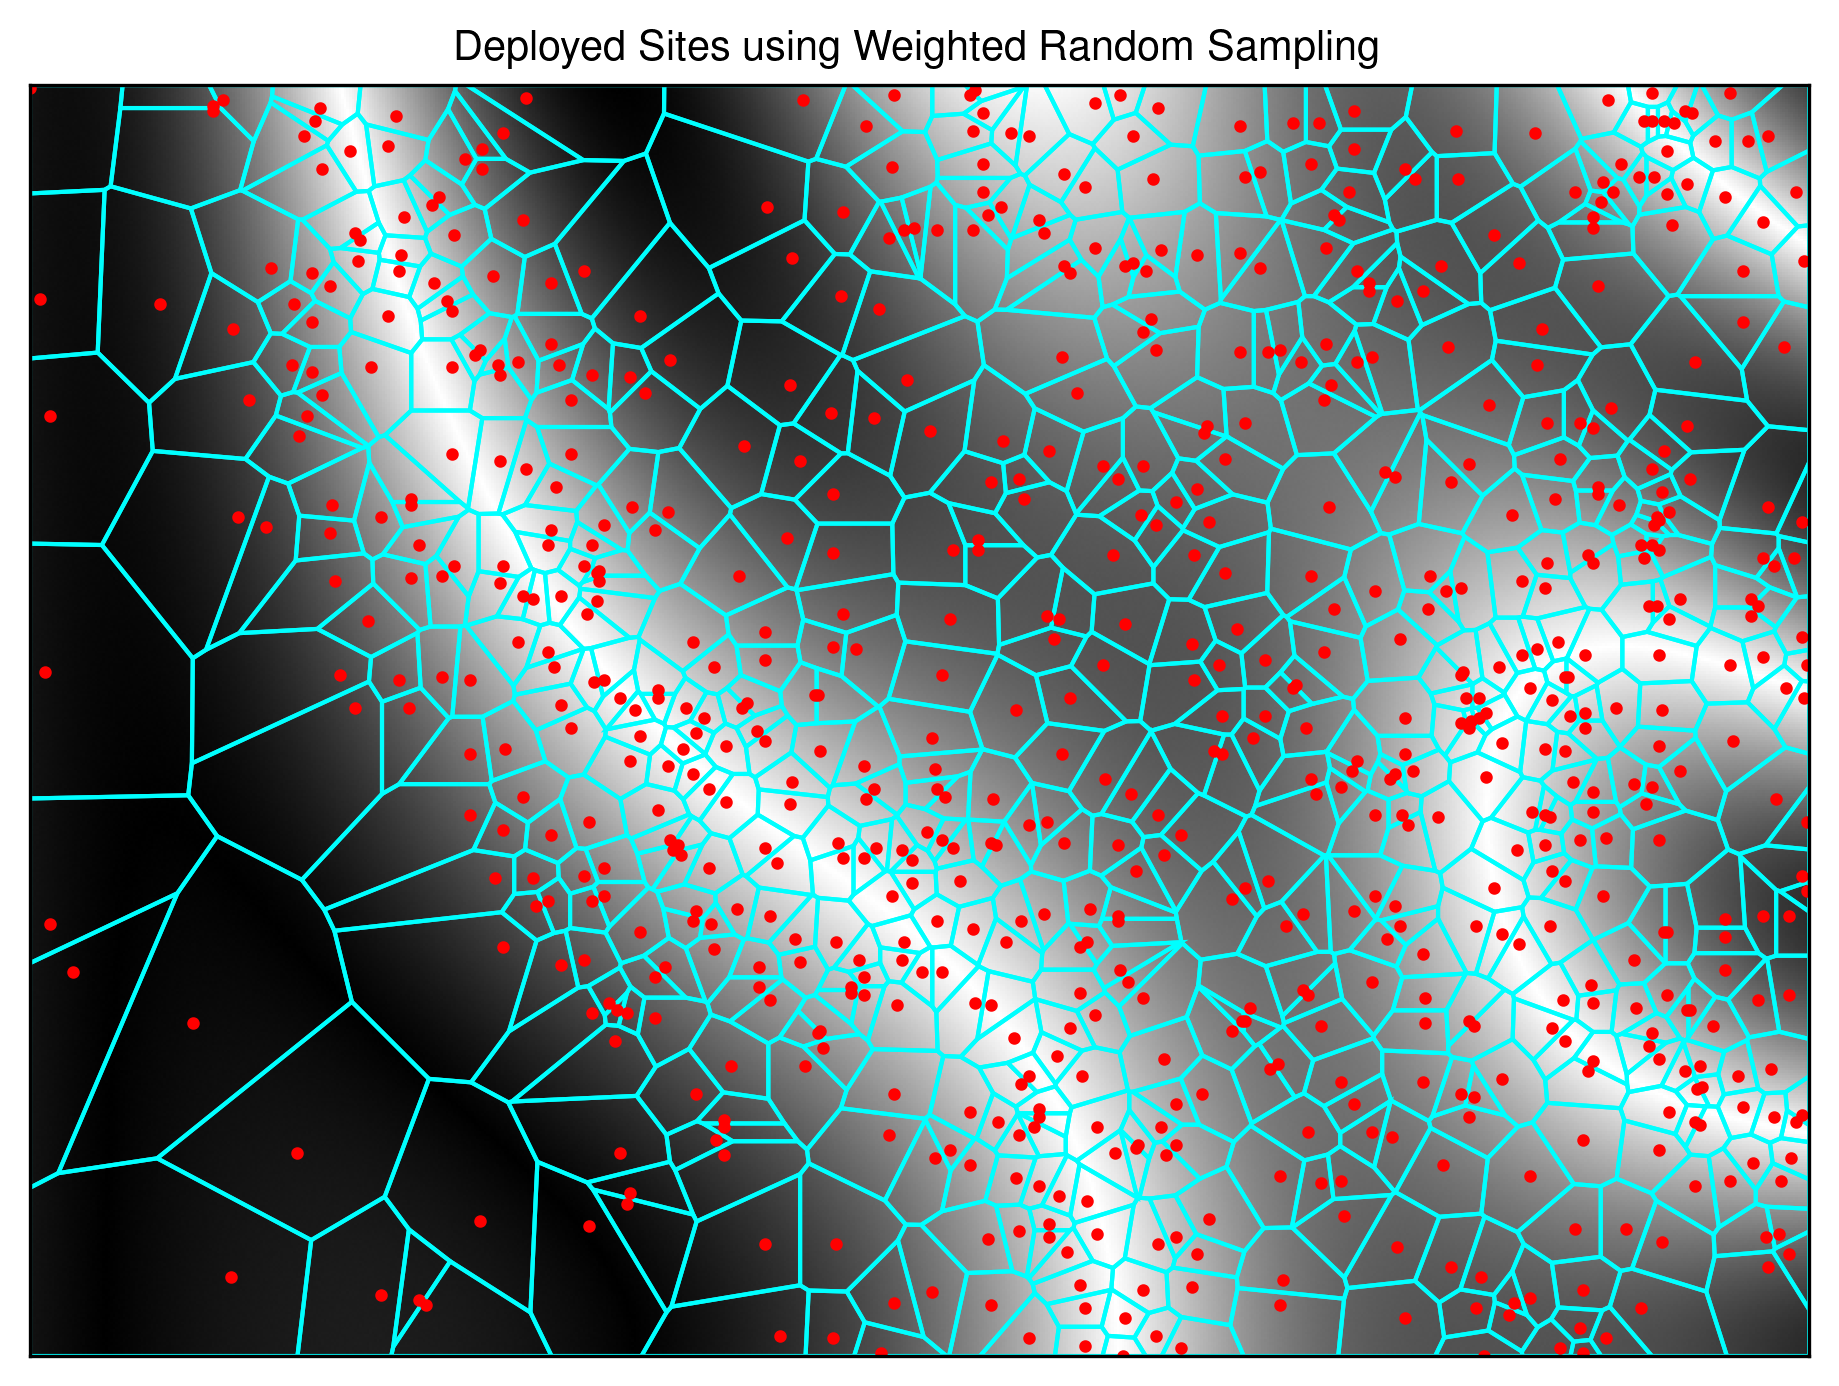

In [15]:
N = 750

# Use the image intensities as the weights for each pixel
weights = test_sig.flatten() / np.sum(test_sig)
# Randomly pick an index
idx = np.arange(len(weights))

rand_idx = np.random.choice(idx, N, replace = False, p = weights)

# Get the coordinates of each sampled point
points = np.array([X.flatten()[rand_idx], Y.flatten()[rand_idx]], dtype=float).T

# Get the weights of each site
weights = test_sig.flatten()[rand_idx]

vor = tess.Voronoi(points, (h,w), weights)
vor.plot(transparent=True)

ax = plt.gca()

ax.pcolormesh(X,Y, test_sig, cmap='gray')

ax.set_title("Deployed Sites using Weighted Random Sampling")
plt.show()

Next we distribute these sites on the image using Lloyd's algorithm just as before, only this time we update the weight of each site based on the intensity of the pixel that site is sitting on. To do this I defined a subclass, <code>TesselatedImage</code>, to update the weights as a function of position within the image.

All Centroids within 5.0% after 30 iterations of Lloyd relaxation


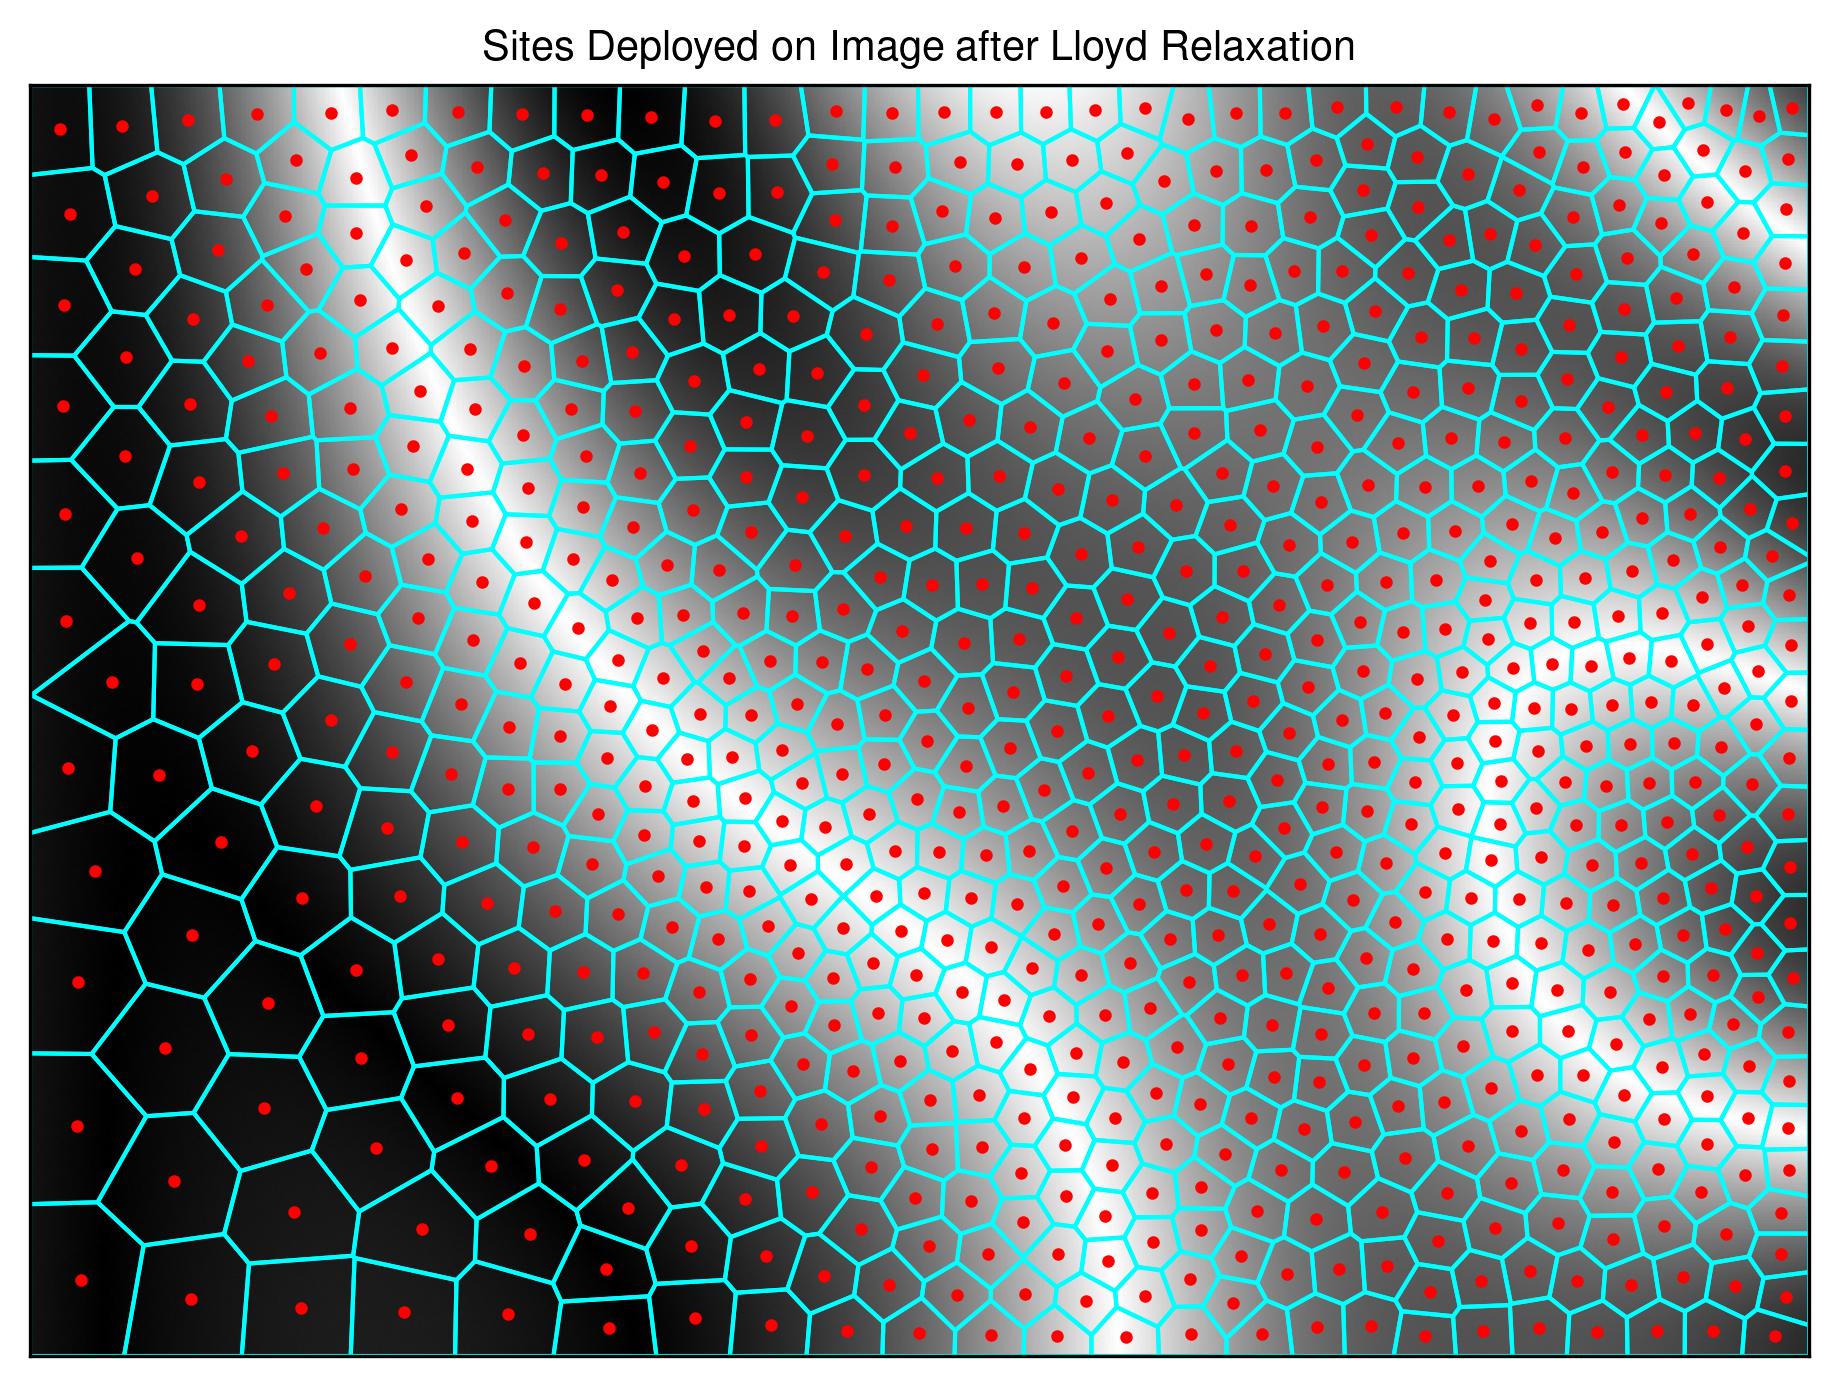

In [16]:
img_tess = tess.TesselatedImage(points, test_sig)

img_tess.lloyd()

fig, ax = plt.subplots()

ax.pcolormesh(X,Y, test_sig, cmap='gray')
img_tess.plot(ax=ax, transparent=True)

ax.set_title("Sites Deployed on Image after Lloyd Relaxation")

#plt.savefig('lloyd_on_image.png')
plt.show()
